In [58]:
import os
import glob
import cv2
import json
import numpy as np
from tqdm import tqdm
from pycocotools.coco import COCO
import matplotlib.pyplot as plt

In [59]:
DATASET_DIR = "_data/synthetic_leaf_instances"

OUT_DIR = "out/validation"

In [60]:
os.makedirs(OUT_DIR, exist_ok=True)

In [61]:
total_anns = 0
total_imgs = 0
for directory in [file for file in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, file))]:
    if directory != 'val':
        continue
        #pass
    #globs = glob.glob(f"{os.path.join(DATASET_DIR, directory)}/*.json")
    #print(globs)
    #annotation_file = globs[0]
    annotation_file = "_data/coco_synthetic_val.json"
    coco = COCO(annotation_file)
    cat_ids = coco.getCatIds()
    for img_data in coco.imgs.values():
        img_file = os.path.join(directory, img_data['file_name'])
        anns_ids = coco.getAnnIds(imgIds=img_data['id'], catIds=cat_ids, iscrowd=None)
        anns = coco.loadAnns(anns_ids)
        total_anns += len(anns)
        total_imgs += 1
    
print(f"#Images: {total_imgs}, #Annotations: {total_anns}, Annotations per Image: {total_anns/total_imgs}")

loading annotations into memory...
Done (t=1.03s)
creating index...
index created!
#Images: 1999, #Annotations: 8932, Annotations per Image: 4.468234117058529


In [62]:
def extract_image_masks(directory, annotation_file=None):
    result = []
    if annotation_file is None:
        annotation_file = glob.glob(f"{directory}/*.json")[0]
    coco = COCO(annotation_file)
    cat_ids = coco.getCatIds()
    for img_data in coco.imgs.values():
        img_file = os.path.join(directory, img_data['file_name'])
        img = cv2.imread(img_file)
        anns_ids = coco.getAnnIds(imgIds=img_data['id'], catIds=cat_ids, iscrowd=None)
        anns = coco.loadAnns(anns_ids)
        anns.sort(key=lambda x: x["area"])
        masks = []
        for i, ann in enumerate(anns):
            ann_mask = coco.annToMask(ann)
            masks.append(ann_mask)
        result.append((img, masks))
    return result

In [63]:
image_masks = []
for directory in [file for file in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, file))]:
    if directory != 'val':
        continue
        #pass
    print(f"Processing {directory}")
    image_masks += extract_image_masks(os.path.join(DATASET_DIR, directory, "images"), "_data/coco_synthetic_val.json")
print(f"Found {len(image_masks)}")

Processing val
loading annotations into memory...
Done (t=1.00s)
creating index...
index created!
Found 1999


In [ ]:
import random
image, mask = random.sample(image_masks, 1)[0]
plt.figure()
plt.imshow(image)
overlay = np.zeros(image.shape[:2] + (4,))
for val in np.unique(mask):
    if val == 0:
        continue
    binary_mask = mask[:, :, 0] == val
    overlay[binary_mask, :] = np.concatenate([np.random.random(3), [.5]])
ax = plt.gca()
ax.set_autoscale_on(False)
plt.imshow(overlay)
plt.show()

In [64]:
def get_patches(masks, image, apply_mask=False, padding=0):
    result = []
    
    for mask in masks:
        if apply_mask:
            image_tmp = image * (mask["segmentation"][:, :, np.newaxis])
        else:
            image_tmp = image
        
        bbox = mask["bbox"]
        x0 = bbox[1]-padding
        if x0 < 0:
            x0 = 0
        x1 = bbox[1]+bbox[3]+padding
        if x1 >= image.shape[0]:
            x1 = image.shape[0] - 1
        y0 = bbox[0]-padding
        if y0 < 0:
            y0 = 0
        y1 = bbox[0]+bbox[2]+padding
        if y1 >= image.shape[1]:
            y1 = image.shape[1] - 1
        
        patch = image_tmp[int(x0):int(x1), int(y0):int(y1)]
        
        if 0 in patch.shape:
            continue
        result.append(patch)
    
    return result

# PyTorch models

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50, ResNet50_Weights

In [45]:
# Check if GPU is available
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [46]:
class BinaryResnetClassifier(nn.Module):
    def __init__(self, num_classes=1):
        super(BinaryResnetClassifier, self).__init__()
        # Load a pre-trained ResNet model
        self.resnet = resnet50(ResNet50_Weights.IMAGENET1K_V1)  # You can choose any ResNet variant
        # Modify the last fully connected layer
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
        nn.init.xavier_normal_(self.resnet.fc.weight)
        
    def forward(self, x):
        # Pass the input through the ResNet
        x = self.resnet(x)
        # Apply the sigmoid activation function
#        x = torch.sigmoid(x)  # Output will be between 0 and 1
        return x

In [47]:
class Encoder(nn.Module):
    def __init__(self, in_channels=3, out_channels=16, latent_dim=200, act_fn=nn.ReLU()):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, stride=2),  # 112x112
            act_fn,
            nn.Conv2d(out_channels, 2*out_channels, 3, padding=1, stride=2),  # 56x56
            act_fn,
            nn.Conv2d(2*out_channels, 4*out_channels, 3, padding=1, stride=2),  # 28x28
            act_fn,
            nn.Conv2d(4*out_channels, 8*out_channels, 3, padding=1, stride=2),  # 14x14
            act_fn,
            nn.Conv2d(8*out_channels, 16*out_channels, 3, padding=1, stride=2),  # 7x7
            act_fn,
            nn.Flatten(),
            nn.Linear(16*out_channels*7*7, latent_dim),
            act_fn
        )

    def forward(self, x):
        return self.net(x)

class Decoder(nn.Module):
    def __init__(self, in_channels=3, out_channels=16, latent_dim=200, act_fn=nn.ReLU()):
        super().__init__()
        self.out_channels = out_channels
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 16*out_channels*7*7),
            act_fn
        )
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(16*out_channels, 8*out_channels, 3, stride=2, padding=1, output_padding=1),  # 14x14
            act_fn,
            nn.ConvTranspose2d(8*out_channels, 4*out_channels, 3, stride=2, padding=1, output_padding=1),  # 28x28
            act_fn,
            nn.ConvTranspose2d(4*out_channels, 2*out_channels, 3, stride=2, padding=1, output_padding=1),  # 56x56
            act_fn,
            nn.ConvTranspose2d(2*out_channels, out_channels, 3, stride=2, padding=1, output_padding=1),  # 112x112
            act_fn,
            nn.ConvTranspose2d(out_channels, in_channels, 3, stride=2, padding=1, output_padding=1),  # 224x224
        )

    def forward(self, x):
        output = self.linear(x)
        output = output.view(-1, 16*self.out_channels, 7, 7)
        output = self.conv(output)
        return output

#  defining autoencoder
class BigAutoencoder(nn.Module):
    def __init__(self, encoder=Encoder(), decoder=Decoder()):
        super().__init__()
        self.encoder = encoder
#        self.encoder.to(device)

        self.decoder = decoder
#        self.decoder.to(device)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [66]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from ultralytics import YOLO
import torchvision.transforms.v2 as transforms

yolo = YOLO("out/yolo_urban_street/train/weights/best.pt")
yolo_syn = YOLO("out/yolo_synthetic/train4/weights/best.pt")

resnet = torch.load("out/leaf_classifier/resnet/resnet_latest.pth")
resnet = resnet.to(device)
resnet.eval()

resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.RandomAffine(180, shear=45),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
])


autoencoder = torch.load("out/leaf_classifier/autoencoder/autoencoder_latest.pth")
autoencoder.eval()

autoencoder_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
])

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

def predict_sam(img, pred, apply_mask=False):
    masks = mask_generator.generate(img)
    masks.sort(key=lambda x: x["area"])
    patches = get_patches(masks, img, apply_mask)
    result = []
    
    for i, (mask, patch) in enumerate(zip(masks, patches)):
        if pred(patch):
            result.append(mask["segmentation"] > 0)
    return result
    
def prep_img(img):
    return torch.Tensor(img).to(device).permute(2, 0, 1).unsqueeze(0)

def predict_sam_autoencoder(img):
    def pred(x):
        x = autoencoder_transform(prep_img(x))
        gt = autoencoder_transform(prep_img(img
                                           ))
        with torch.no_grad():
            val = torch.sigmoid(nn.MSELoss()(autoencoder(x), gt)).item()
            return val < .75
    return predict_sam(img, pred, True)
    
def predict_sam_resnet(img):
    def pred(x):
        x = resnet_transform(prep_img(x))
        with torch.no_grad():
            return resnet(x).item() > .5
    return predict_sam(img, pred)
    
def predict_sam_yolo(img):
    return predict_sam(img, lambda x: yolo.predict(x)[0].masks is not None)
    
def predict_yolo(image):
    result = yolo_syn.predict(image)[0].masks
    if result is None:
        return np.zeros(image.shape[:2])
    return result.data.cpu().numpy()

In [67]:
prediction_dict = {
    "YOLOv8": predict_yolo,
    "SAM + ResNet": predict_sam_resnet,
    "SAM + Autoencoder": predict_sam_autoencoder,
    "SAM + YOLOv8": predict_sam_yolo,
}

# Tensorflow Models

In [1]:
import os
import cv2
import numpy as np
from PIL import Image
import tensorflow as tf
import tensorflow_models as tfm
from official.vision.utils.object_detection import visualization_utils
from official.vision.ops.preprocess_ops import normalize_image, resize_and_crop_image
tf.get_logger().setLevel('ERROR')

In [2]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
    path: the file path to the image

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """
    image = None
    if(path.startswith('http')):
        response = urlopen(path)
        image_data = response.read()
        image_data = BytesIO(image_data)
        image = Image.open(image_data)
    else:
        image = Image.open(path)

    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)

def build_inputs_for_object_detection(image, input_image_size):
    """Builds Object Detection model inputs for serving."""
    return cv2.resize(image.squeeze(), input_image_size)
    image, _ = resize_and_crop_image(
      image,
      input_image_size,
      padded_size=input_image_size,
      aug_scale_min=1.0,
      aug_scale_max=1.0)
    return image

In [18]:
def reframe_image_corners_relative_to_boxes(boxes):
    """Reframe the image corners ([0, 0, 1, 1]) to be relative to boxes.
    The local coordinate frame of each box is assumed to be relative to
    its own for corners.
    Args:
    boxes: A float tensor of [num_boxes, 4] of (ymin, xmin, ymax, xmax)
      coordinates in relative coordinate space of each bounding box.
    Returns:
    reframed_boxes: Reframes boxes with same shape as input.
    """
    ymin, xmin, ymax, xmax = (boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3])

    height = tf.maximum(ymax - ymin, 1e-4)
    width = tf.maximum(xmax - xmin, 1e-4)

    ymin_out = (0 - ymin) / height
    xmin_out = (0 - xmin) / width
    ymax_out = (1 - ymin) / height
    xmax_out = (1 - xmin) / width
    return tf.stack([ymin_out, xmin_out, ymax_out, xmax_out], axis=1)

def reframe_box_masks_to_image_masks(box_masks, boxes, image_height,
                                     image_width, resize_method='bilinear'):
    """Transforms the box masks back to full image masks.
    Embeds masks in bounding boxes of larger masks whose shapes correspond to
    image shape.
    Args:
    box_masks: A tensor of size [num_masks, mask_height, mask_width].
    boxes: A tf.float32 tensor of size [num_masks, 4] containing the box
           corners. Row i contains [ymin, xmin, ymax, xmax] of the box
           corresponding to mask i. Note that the box corners are in
           normalized coordinates.
    image_height: Image height. The output mask will have the same height as
                  the image height.
    image_width: Image width. The output mask will have the same width as the
                 image width.
    resize_method: The resize method, either 'bilinear' or 'nearest'. Note that
      'bilinear' is only respected if box_masks is a float.
    Returns:
    A tensor of size [num_masks, image_height, image_width] with the same dtype
    as `box_masks`.
    """
    resize_method = 'nearest' if box_masks.dtype == tf.uint8 else resize_method
    # TODO(rathodv): Make this a public function.
    def reframe_box_masks_to_image_masks_default():
        """The default function when there are more than 0 box masks."""

        num_boxes = tf.shape(box_masks)[0]
        box_masks_expanded = tf.expand_dims(box_masks, axis=3)

        resized_crops = tf.image.crop_and_resize(
            image=box_masks_expanded,
            boxes=reframe_image_corners_relative_to_boxes(boxes),
            box_indices=tf.range(num_boxes),
            crop_size=[image_height, image_width],
            method=resize_method,
            extrapolation_value=0)
        return tf.cast(resized_crops, box_masks.dtype)

    image_masks = tf.cond(
        tf.shape(box_masks)[0] > 0,
        reframe_box_masks_to_image_masks_default,
        lambda: tf.zeros([0, image_height, image_width, 1], box_masks.dtype))
    return tf.squeeze(image_masks, axis=3)

def reframe_masks(masks, boxes, image_shape):
    result = []
    for box, mask in zip(boxes, masks):
        box = tf.cast(box, np.uint16)
        box = box.numpy()
        if len(np.unique(box)) == 1:
            continue
        mask = mask.numpy()
        ymin, xmin, ymax, xmax = (box[0], box[1], box[2], box[3])
        box_width = xmax - xmin
        box_height = ymax - ymin
        mask_resized = cv2.resize(mask, (box_width, box_height))
        total_mask = np.zeros(image_shape[:2])

        total_mask[ymin:ymax, xmin:xmax] = mask_resized
        result.append(total_mask)
    return np.stack(result) if len(result) > 0 else np.array([])

In [19]:
imported = tf.saved_model.load("out/maskrcnn_resnet_fpn_16_09_24/final")
model_fn = imported.signatures['serving_default']

In [20]:
def predict_maskrcnn(image):
    min_score_thresh = .2
    input_image_size = (640, 640)
    image_tf = tf.convert_to_tensor(image)
    image_tf = tf.expand_dims(image_tf, axis=0)
    image_tf = tf.cast(image_tf, dtype = tf.uint8)
    result = model_fn(image_tf)
    if 'detection_masks' in result:
        detection_masks = tf.convert_to_tensor(result['detection_masks'][0])
        detection_boxes = tf.convert_to_tensor(result['detection_boxes'][0])
#        detection_masks_reframed = reframe_box_masks_to_image_masks(
#                  detection_masks, detection_boxes/256.0,
#                    image.shape[0], image.shape[1])
        detection_masks_reframed = reframe_masks(detection_masks, detection_boxes, image.shape)
        detection_masks_reframed = tf.cast(
            detection_masks_reframed > min_score_thresh,
            np.uint8)
        masks = []
        for mask in detection_masks_reframed:
            mask = mask.numpy()
            # skip empty masks
            if (len(np.unique(mask)) == 1):
                continue
            else:
                masks.append(mask)
        return masks
    else:
        return []

In [21]:
prediction_dict = {
    "MaskRCNN": predict_maskrcnn,
}

In [38]:
import random
img_files = [file for file in [os.path.join("_data/combined/test", file) for file in random.sample(os.listdir("_data/combined/test"), k=1)] if os.path.isfile(file)]

dict_keys(['detection_classes', 'image_info', 'detection_masks', 'num_detections', 'detection_boxes', 'detection_scores'])
511.72726


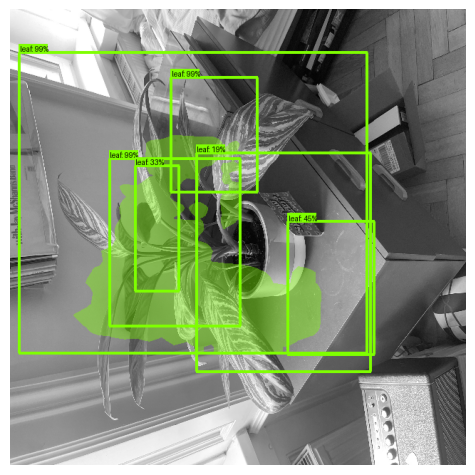

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
# code source from
# https://github.com/tensorflow/models/blob/master/docs/vision/instance_segmentation.ipynb

HEIGHT = 640
WIDTH = 640
input_image_size = (HEIGHT, WIDTH)
plt.figure(figsize=(20, 20))
min_score_thresh = 0.10 # Change minimum score for threshold to see all bounding boxes confidences

category_index = {
    0: {
        'id': 0,
        'name': 'background'
    },
    1: {
        'id': 32,
        'name': 'leaf'
    },
}

for i, img_file in enumerate(img_files):
    plt.subplot(1, 3, i+1)
    image = load_image_into_numpy_array(img_file)
    image = build_inputs_for_object_detection(image, input_image_size)
    image = tf.expand_dims(image, axis=0)
    image = tf.cast(image, dtype = tf.uint8)
    image_np = image[0].numpy()
    result = model_fn(image)
    print(result.keys())
    # Visualize detection and masks
    if 'detection_masks' in result:
        # we need to convert np.arrays to tensors
        detection_masks = tf.convert_to_tensor(result['detection_masks'][0])
        detection_boxes = tf.convert_to_tensor(result['detection_boxes'][0])
        detection_masks_reframed = reframe_box_masks_to_image_masks(
                  detection_masks, detection_boxes/256.0,
                    image_np.shape[0], image_np.shape[1])
        detection_masks_reframed = reframe_masks(detection_masks, detection_boxes, image_np.shape)
#        print(detection_masks_reframed.numpy().max())
        detection_masks_reframed = tf.cast(
            detection_masks_reframed > min_score_thresh,
            np.uint8)
        
        result['detection_masks_reframed'] = detection_masks_reframed.numpy()
    print(result['detection_boxes'].numpy().max())
    image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)
    image_np = np.stack((image_np,)*3, axis=-1)
    visualization_utils.visualize_boxes_and_labels_on_image_array(
        image_np,
        result['detection_boxes'][0].numpy(),
        (result['detection_classes'][0] + 0).numpy().astype(int),
        result['detection_scores'][0].numpy(),
        category_index=category_index,
        use_normalized_coordinates=False,
        max_boxes_to_draw=100,
        min_score_thresh=min_score_thresh,
        instance_masks=result.get('detection_masks_reframed', None),
        line_thickness=4)
    
    plt.imshow(image_np, cmap='gray')
    plt.axis("off")

plt.show()

122 511 246 511
4 315 9 512
56 507 49 512
4 193 185 487
14 50 394 452
110 179 303 401
86 200 207 410
300 461 227 498
196 306 261 361
219 345 72 182
186 386 22 395
168 408 180 491


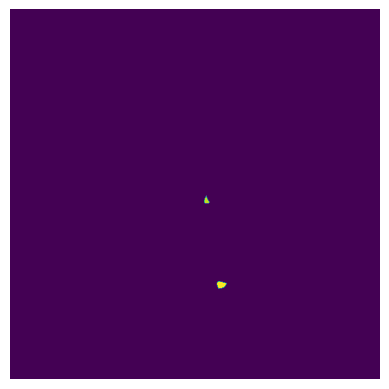

In [58]:
%matplotlib inline
img_file = img_files[0]
image = load_image_into_numpy_array(img_file)
image = build_inputs_for_object_detection(image, input_image_size)
image = tf.expand_dims(image, axis=0)
image = tf.cast(image, dtype = tf.uint8)
image_np = image[0].numpy()
output = model_fn(image)

combined_masks = np.zeros(image_np.shape[:2])

for i, (box, mask) in enumerate(zip(output["detection_boxes"][0], output["detection_masks"][0])):
    box = tf.cast(box, np.uint16)
    box = box.numpy()
    if len(np.unique(box)) == 1:
        continue
    mask = mask.numpy()
    ymin, xmin, ymax, xmax = (box[0], box[1], box[2], box[3])
    box_width = xmax - xmin
    box_height = ymax - ymin
    mask_resized = cv2.resize(mask, (box_width, box_height))
    total_mask = np.zeros(image_np.shape[:2])
    
    total_mask[ymin:ymax, xmin:xmax] = mask_resized
    combined_masks[total_mask > .2] = i
    
plt.imshow(combined_masks)
plt.axis('off')
plt.show()

# Test execution

In [50]:
%matplotlib inline
def compare_segmentation_masks(mask1, mask2, img):
    # Ensure that both masks are binary and of the same shape
    assert mask1.shape == mask2.shape, "Masks must have the same shape"
    
    # Create a figure and clear any previous plots
    plt.figure(figsize=(10, 5))
    plt.clf()  # Clear the figure to overwrite the previous one

    # Plot the first mask
    plt.subplot(1, 4, 1)
    plt.title('Mask 1')
    plt.imshow(mask1, cmap='gray')
    plt.axis('off')

    # Plot the second mask
    plt.subplot(1, 4, 2)
    plt.title('Mask 2')
    plt.imshow(mask2, cmap='gray')
    plt.axis('off')

    # Create a difference mask (where masks disagree)
    difference_mask = (mask1 != mask2).astype(np.float32)

    # Plot the difference between the two masks
    plt.subplot(1, 4, 3)
    plt.title('Difference (Mask1 != Mask2)')
    plt.imshow(difference_mask, cmap='Reds')
    plt.axis('off')
    
    plt.subplot(1, 4, 4) # Plot the difference between the two masks
    plt.title('Image')
    plt.imshow(img)
    plt.axis('off')

    # Show the comparison
    plt.tight_layout()
    plt.show()

In [51]:
import pandas as pd

In [52]:
def iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    if union == 0:
        return 0
    return intersection / union

# Function to calculate Dice coefficient between two masks
def dice(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    sum_areas = mask1.sum() + mask2.sum()
    if sum_areas == 0:
        return 0
    return 2 * intersection / sum_areas

In [53]:
from scipy.optimize import linear_sum_assignment

def match_masks(pred_masks, gt_masks, iou_threshold=0.5):
    iou_matrix = np.zeros((len(pred_masks), len(gt_masks)))

    # Calculate IoU for each pair of predicted and ground truth masks
    for i, pred in enumerate(pred_masks):
        for j, gt in enumerate(gt_masks):
            iou_matrix[i, j] = iou(pred, gt)

    # Use Hungarian algorithm for optimal matching
    pred_indices, gt_indices = linear_sum_assignment(-iou_matrix)

    # True Positives (TP), False Positives (FP), False Negatives (FN)
    tp = 0
    fp = 0
    fn = 0
    matched_pairs = []
    iou_scores = []
    dice_scores = []

    for i, j in zip(pred_indices, gt_indices):
        if iou_matrix[i, j] >= iou_threshold:
            tp += 1
            matched_pairs.append((i, j))  # Store matched pairs for further analysis
            iou_scores.append(iou_matrix[i, j])  # IoU for this matched pair
            dice_scores.append(dice(pred_masks[i], gt_masks[j]))  # Dice for this matched pair
        else:
            fp += 1

    fn = len(gt_masks) - tp  # Unmatched ground truth masks are false negatives
    fp += len(pred_masks) - tp  # Unmatched predicted masks are false positives

    return tp, fp, fn, matched_pairs, iou_scores, dice_scores

In [54]:
# Function to calculate True Negatives (TN)
def calculate_true_negatives(gt_masks, pred_masks):
    # Combine all gt_masks into one binary mask (0: background, 1: object)
    gt_combined = np.sum(gt_masks, axis=0) > 0
    pred_combined = np.sum(pred_masks, axis=0) > 0
    
    # Calculate True Negatives
    true_negative_mask = np.logical_and(gt_combined == 0, pred_combined == 0)
    tn = np.sum(true_negative_mask)
    
    return tn

In [55]:
def compute_metrics(tp, fp, fn, tn):
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return precision, recall, specificity, f1_score

In [56]:
def evaluate_instance_segmentation(gt_masks, pred_masks, iou_threshold=0.5):
    tp, fp, fn, matched_pairs, iou_scores, dice_scores = match_masks(pred_masks, gt_masks, iou_threshold)
    
    # Calculate True Negatives
    tn = calculate_true_negatives(gt_masks, pred_masks)
    
    # Calculate Precision, Recall, Specificity, and F1 Score
    precision, recall, specificity, f1_score = compute_metrics(tp, fp, fn, tn)
    
    # Calculate mean IoU and mean Dice score
    mean_iou = np.mean(iou_scores) if iou_scores else 0
    mean_dice = np.mean(dice_scores) if dice_scores else 0
    
    return {
        "true_positives": tp,
        "false_positives": fp,
        "false_negatives": fn,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "mean_iou": mean_iou,
        "mean_dice": mean_dice,
        "specificity": specificity
    }

In [68]:
results = dict()
result_dfs = dict()
for name, func in prediction_dict.items():
    df = pd.DataFrame()
    result = []
    for img, gt_masks in tqdm(image_masks, desc=f"Evaluating {name}"):
        pred_masks = func(img)
        eval_results = evaluate_instance_segmentation(gt_masks, pred_masks)
        df = pd.concat([df, pd.DataFrame(eval_results, index=range(len(eval_results)))], ignore_index=True)
        result.append(eval_results)
    results[name] = result
    result_dfs[name] = df
    df.to_csv(os.path.join(OUT_DIR, f"{name}.csv"))

Evaluating YOLOv8:   0%|          | 0/1999 [00:00<?, ?it/s]


0: 640x640 5 leafs, 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   0%|          | 1/1999 [00:00<10:23,  3.20it/s]


0: 640x640 1 leaf, 8.5ms
Speed: 1.6ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.5ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.4ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.5ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   0%|          | 5/1999 [00:00<02:19, 14.28it/s]


0: 640x640 5 leafs, 8.0ms
Speed: 1.4ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 12.2ms
Speed: 1.5ms preprocess, 12.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   0%|          | 8/1999 [00:00<02:21, 14.04it/s]


0: 640x640 3 leafs, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   1%|          | 10/1999 [00:00<02:11, 15.18it/s]


0: 640x640 2 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   1%|          | 14/1999 [00:00<01:49, 18.14it/s]


0: 640x640 2 leafs, 8.3ms
Speed: 1.6ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   1%|          | 18/1999 [00:01<01:28, 22.50it/s]


0: 640x640 1 leaf, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   1%|          | 21/1999 [00:01<01:33, 21.12it/s]


0: 640x640 6 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   1%|          | 24/1999 [00:01<01:36, 20.38it/s]


0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 7.7ms
Speed: 1.6ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   1%|▏         | 27/1999 [00:01<01:48, 18.21it/s]


0: 640x640 2 leafs, 8.7ms
Speed: 1.8ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   2%|▏         | 30/1999 [00:01<01:46, 18.43it/s]


0: 640x640 10 leafs, 8.3ms
Speed: 1.6ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.2ms
Speed: 1.5ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   2%|▏         | 32/1999 [00:01<02:03, 15.91it/s]


0: 640x640 4 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 8.7ms
Speed: 1.6ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   2%|▏         | 35/1999 [00:02<01:57, 16.74it/s]


0: 640x640 4 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.7ms
Speed: 1.6ms preprocess, 8.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.2ms
Speed: 1.5ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   2%|▏         | 38/1999 [00:02<01:47, 18.22it/s]


0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.6ms
Speed: 1.6ms preprocess, 8.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   2%|▏         | 43/1999 [00:02<01:22, 23.69it/s]


0: 640x640 6 leafs, 8.3ms
Speed: 1.6ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.3ms
Speed: 1.8ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   2%|▏         | 46/1999 [00:02<01:23, 23.38it/s]


0: 640x640 7 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.6ms
Speed: 1.6ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   2%|▏         | 49/1999 [00:02<01:39, 19.52it/s]


0: 640x640 5 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   3%|▎         | 52/1999 [00:02<01:36, 20.13it/s]


0: 640x640 6 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   3%|▎         | 55/1999 [00:02<01:29, 21.80it/s]


0: 640x640 1 leaf, 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 9 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   3%|▎         | 58/1999 [00:03<01:30, 21.53it/s]


0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 7.9ms
Speed: 1.5ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   3%|▎         | 62/1999 [00:03<01:17, 25.07it/s]


0: 640x640 6 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   3%|▎         | 65/1999 [00:03<01:19, 24.23it/s]


0: 640x640 4 leafs, 8.6ms
Speed: 1.7ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.3ms
Speed: 2.4ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   3%|▎         | 69/1999 [00:03<01:10, 27.45it/s]


0: 640x640 7 leafs, 10.3ms
Speed: 1.8ms preprocess, 10.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 9.0ms
Speed: 1.6ms preprocess, 9.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 9.0ms
Speed: 1.6ms preprocess, 9.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   4%|▎         | 72/1999 [00:03<01:23, 23.05it/s]


0: 640x640 4 leafs, 9.0ms
Speed: 1.6ms preprocess, 9.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 11.7ms
Speed: 1.6ms preprocess, 11.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   4%|▍         | 75/1999 [00:03<01:38, 19.63it/s]


0: 640x640 1 leaf, 10.4ms
Speed: 1.6ms preprocess, 10.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 9.0ms
Speed: 1.6ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 9.3ms
Speed: 1.6ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   4%|▍         | 78/1999 [00:03<01:32, 20.80it/s]


0: 640x640 1 leaf, 9.0ms
Speed: 1.6ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 9.1ms
Speed: 1.7ms preprocess, 9.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 12.3ms
Speed: 1.7ms preprocess, 12.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   4%|▍         | 81/1999 [00:04<01:29, 21.36it/s]


0: 640x640 1 leaf, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.4ms
Speed: 1.7ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   4%|▍         | 86/1999 [00:04<01:12, 26.45it/s]


0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   4%|▍         | 89/1999 [00:04<01:17, 24.71it/s]


0: 640x640 2 leafs, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   5%|▍         | 93/1999 [00:04<01:12, 26.31it/s]


0: 640x640 2 leafs, 12.0ms
Speed: 1.5ms preprocess, 12.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 12.5ms
Speed: 1.7ms preprocess, 12.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 11.7ms
Speed: 1.6ms preprocess, 11.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   5%|▍         | 96/1999 [00:04<01:12, 26.17it/s]


0: 640x640 3 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   5%|▌         | 100/1999 [00:04<01:07, 28.22it/s]


0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 10.2ms
Speed: 1.7ms preprocess, 10.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 10 leafs, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   5%|▌         | 103/1999 [00:04<01:25, 22.15it/s]


0: 640x640 1 leaf, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.3ms
Speed: 1.6ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   5%|▌         | 107/1999 [00:05<01:17, 24.49it/s]


0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 8.0ms
Speed: 2.1ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   6%|▌         | 110/1999 [00:05<01:22, 22.88it/s]


0: 640x640 (no detections), 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 12.8ms
Speed: 1.6ms preprocess, 12.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   6%|▌         | 113/1999 [00:05<01:51, 16.98it/s]


0: 640x640 1 leaf, 12.4ms
Speed: 1.6ms preprocess, 12.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 11.8ms
Speed: 1.6ms preprocess, 11.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   6%|▌         | 117/1999 [00:05<01:32, 20.35it/s]


0: 640x640 3 leafs, 7.9ms
Speed: 1.9ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   6%|▌         | 120/1999 [00:05<01:28, 21.17it/s]


0: 640x640 4 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   6%|▌         | 124/1999 [00:05<01:16, 24.58it/s]


0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   6%|▋         | 128/1999 [00:06<01:14, 25.24it/s]


0: 640x640 5 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.3ms
Speed: 1.8ms preprocess, 8.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   7%|▋         | 131/1999 [00:06<01:20, 23.17it/s]


0: 640x640 4 leafs, 8.6ms
Speed: 1.7ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 7.8ms
Speed: 1.7ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   7%|▋         | 134/1999 [00:06<01:19, 23.49it/s]


0: 640x640 4 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   7%|▋         | 139/1999 [00:06<01:05, 28.26it/s]


0: 640x640 6 leafs, 8.4ms
Speed: 1.7ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 11.2ms
Speed: 1.6ms preprocess, 11.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 11.4ms
Speed: 1.6ms preprocess, 11.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   7%|▋         | 142/1999 [00:06<01:13, 25.36it/s]


0: 640x640 4 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.5ms
Speed: 1.6ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   7%|▋         | 145/1999 [00:06<01:21, 22.84it/s]


0: 640x640 4 leafs, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   7%|▋         | 148/1999 [00:06<01:25, 21.55it/s]


0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   8%|▊         | 152/1999 [00:07<01:14, 24.88it/s]


0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   8%|▊         | 155/1999 [00:07<01:13, 25.16it/s]


0: 640x640 2 leafs, 8.6ms
Speed: 1.7ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   8%|▊         | 158/1999 [00:07<01:10, 25.94it/s]


0: 640x640 4 leafs, 7.4ms
Speed: 1.7ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.3ms
Speed: 1.6ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   8%|▊         | 161/1999 [00:07<01:15, 24.47it/s]


0: 640x640 6 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 11.6ms
Speed: 1.6ms preprocess, 11.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   8%|▊         | 164/1999 [00:07<01:29, 20.40it/s]


0: 640x640 5 leafs, 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   8%|▊         | 167/1999 [00:07<01:34, 19.38it/s]


0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   9%|▊         | 170/1999 [00:07<01:42, 17.85it/s]


0: 640x640 2 leafs, 8.3ms
Speed: 1.8ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   9%|▊         | 174/1999 [00:08<01:21, 22.27it/s]


0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   9%|▉         | 178/1999 [00:08<01:17, 23.35it/s]


0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   9%|▉         | 182/1999 [00:08<01:14, 24.55it/s]


0: 640x640 2 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   9%|▉         | 185/1999 [00:08<01:13, 24.76it/s]


0: 640x640 3 leafs, 11.7ms
Speed: 1.6ms preprocess, 11.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 11.5ms
Speed: 1.6ms preprocess, 11.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   9%|▉         | 188/1999 [00:08<01:15, 23.91it/s]


0: 640x640 5 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 12.0ms
Speed: 1.6ms preprocess, 12.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  10%|▉         | 191/1999 [00:08<01:23, 21.72it/s]


0: 640x640 1 leaf, 11.9ms
Speed: 1.6ms preprocess, 11.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 9.3ms
Speed: 1.5ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.8ms
Speed: 1.8ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  10%|▉         | 194/1999 [00:08<01:17, 23.43it/s]


0: 640x640 4 leafs, 8.8ms
Speed: 1.6ms preprocess, 8.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 10.8ms
Speed: 1.7ms preprocess, 10.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  10%|▉         | 197/1999 [00:09<01:16, 23.58it/s]


0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 9.5ms
Speed: 1.6ms preprocess, 9.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 11.9ms
Speed: 1.6ms preprocess, 11.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 1.6ms preprocess, 9.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  10%|█         | 201/1999 [00:09<01:07, 26.52it/s]


0: 640x640 4 leafs, 8.9ms
Speed: 1.6ms preprocess, 8.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.9ms
Speed: 1.5ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.8ms
Speed: 1.5ms preprocess, 8.8ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.9ms
Speed: 1.7ms preprocess, 8.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  10%|█         | 205/1999 [00:09<01:04, 27.73it/s]


0: 640x640 1 leaf, 8.9ms
Speed: 1.7ms preprocess, 8.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 12.3ms
Speed: 1.7ms preprocess, 12.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  10%|█         | 209/1999 [00:09<01:05, 27.40it/s]


0: 640x640 2 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 7.9ms
Speed: 1.5ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 10 leafs, 12.4ms
Speed: 1.6ms preprocess, 12.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  11%|█         | 213/1999 [00:09<01:17, 23.06it/s]


0: 640x640 5 leafs, 8.3ms
Speed: 1.9ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.8ms
Speed: 1.7ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  11%|█         | 216/1999 [00:09<01:26, 20.54it/s]


0: 640x640 3 leafs, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  11%|█         | 220/1999 [00:10<02:21, 12.53it/s]


0: 640x640 4 leafs, 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 12.1ms
Speed: 1.6ms preprocess, 12.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  11%|█         | 223/1999 [00:10<02:08, 13.87it/s]


0: 640x640 2 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  11%|█▏        | 226/1999 [00:10<01:51, 15.97it/s]


0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  12%|█▏        | 231/1999 [00:10<01:27, 20.24it/s]


0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  12%|█▏        | 234/1999 [00:10<01:21, 21.77it/s]


0: 640x640 2 leafs, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.8ms
Speed: 1.6ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.8ms
Speed: 1.7ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  12%|█▏        | 238/1999 [00:11<01:15, 23.47it/s]


0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.8ms
Speed: 1.7ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  12%|█▏        | 242/1999 [00:11<01:05, 26.65it/s]


0: 640x640 1 leaf, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  12%|█▏        | 246/1999 [00:11<00:59, 29.33it/s]


0: 640x640 6 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.6ms
Speed: 1.6ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  13%|█▎        | 250/1999 [00:11<01:02, 28.07it/s]


0: 640x640 6 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 12.1ms
Speed: 1.6ms preprocess, 12.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 11.6ms
Speed: 1.6ms preprocess, 11.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  13%|█▎        | 254/1999 [00:11<01:06, 26.30it/s]


0: 640x640 2 leafs, 8.6ms
Speed: 1.7ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  13%|█▎        | 258/1999 [00:11<00:59, 29.26it/s]


0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 9 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.4ms
Speed: 1.8ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  13%|█▎        | 262/1999 [00:12<01:19, 21.95it/s]


0: 640x640 2 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  13%|█▎        | 266/1999 [00:12<01:09, 24.97it/s]


0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.7ms
Speed: 1.7ms preprocess, 8.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  13%|█▎        | 269/1999 [00:12<01:08, 25.12it/s]


0: 640x640 9 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 1.7ms preprocess, 9.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  14%|█▎        | 272/1999 [00:12<01:30, 19.05it/s]


0: 640x640 2 leafs, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 11.7ms
Speed: 2.3ms preprocess, 11.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.3ms
Speed: 1.6ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  14%|█▍        | 275/1999 [00:12<01:24, 20.44it/s]


0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.6ms
Speed: 1.6ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  14%|█▍        | 279/1999 [00:12<01:12, 23.64it/s]


0: 640x640 5 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.3ms
Speed: 1.6ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.5ms
Speed: 1.6ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  14%|█▍        | 283/1999 [00:12<01:08, 24.91it/s]


0: 640x640 5 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  14%|█▍        | 286/1999 [00:12<01:07, 25.20it/s]


0: 640x640 3 leafs, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  14%|█▍        | 289/1999 [00:13<01:34, 18.01it/s]


0: 640x640 3 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  15%|█▍        | 292/1999 [00:13<01:30, 18.84it/s]


0: 640x640 3 leafs, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 11.9ms
Speed: 1.6ms preprocess, 11.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 11.7ms
Speed: 1.6ms preprocess, 11.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  15%|█▍        | 296/1999 [00:13<01:17, 22.05it/s]


0: 640x640 9 leafs, 11.9ms
Speed: 1.6ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  15%|█▍        | 299/1999 [00:13<01:30, 18.72it/s]


0: 640x640 7 leafs, 8.6ms
Speed: 1.9ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  15%|█▌        | 302/1999 [00:13<01:29, 18.99it/s]


0: 640x640 8 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.5ms
Speed: 1.6ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  15%|█▌        | 305/1999 [00:14<01:43, 16.37it/s]


0: 640x640 (no detections), 10.5ms
Speed: 1.6ms preprocess, 10.5ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 9.0ms
Speed: 1.6ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 9.1ms
Speed: 1.5ms preprocess, 9.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  15%|█▌        | 308/1999 [00:14<01:38, 17.11it/s]


0: 640x640 2 leafs, 11.0ms
Speed: 1.6ms preprocess, 11.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 13.5ms
Speed: 1.7ms preprocess, 13.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 9.2ms
Speed: 1.6ms preprocess, 9.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  16%|█▌        | 311/1999 [00:14<01:34, 17.83it/s]


0: 640x640 2 leafs, 8.8ms
Speed: 1.5ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 9.2ms
Speed: 1.7ms preprocess, 9.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 9.5ms
Speed: 1.7ms preprocess, 9.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 9.0ms
Speed: 1.8ms preprocess, 9.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  16%|█▌        | 315/1999 [00:14<01:22, 20.37it/s]


0: 640x640 4 leafs, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.5ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.6ms
Speed: 1.6ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  16%|█▌        | 318/1999 [00:14<01:17, 21.60it/s]


0: 640x640 5 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  16%|█▌        | 321/1999 [00:14<01:17, 21.76it/s]


0: 640x640 6 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  16%|█▌        | 324/1999 [00:15<01:18, 21.43it/s]


0: 640x640 3 leafs, 8.5ms
Speed: 2.0ms preprocess, 8.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 9 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  16%|█▋        | 328/1999 [00:15<01:23, 19.97it/s]


0: 640x640 4 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  17%|█▋        | 331/1999 [00:15<01:54, 14.61it/s]


0: 640x640 5 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  17%|█▋        | 335/1999 [00:15<01:35, 17.34it/s]


0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  17%|█▋        | 339/1999 [00:15<01:23, 19.88it/s]


0: 640x640 2 leafs, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  17%|█▋        | 342/1999 [00:15<01:16, 21.54it/s]


0: 640x640 4 leafs, 8.7ms
Speed: 1.7ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.8ms
Speed: 1.6ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  17%|█▋        | 345/1999 [00:16<01:21, 20.32it/s]


0: 640x640 5 leafs, 8.0ms
Speed: 2.1ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 9 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  17%|█▋        | 348/1999 [00:16<01:27, 18.87it/s]


0: 640x640 8 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  18%|█▊        | 351/1999 [00:16<01:31, 18.00it/s]


0: 640x640 10 leafs, 12.5ms
Speed: 1.6ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  18%|█▊        | 353/1999 [00:16<01:44, 15.76it/s]


0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.6ms
Speed: 1.7ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  18%|█▊        | 358/1999 [00:16<01:14, 21.89it/s]


0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  18%|█▊        | 362/1999 [00:16<01:09, 23.47it/s]


0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  18%|█▊        | 366/1999 [00:17<01:03, 25.88it/s]


0: 640x640 6 leafs, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  18%|█▊        | 369/1999 [00:17<01:10, 23.15it/s]


0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  19%|█▊        | 372/1999 [00:17<01:11, 22.60it/s]


0: 640x640 6 leafs, 8.6ms
Speed: 1.7ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 11.5ms
Speed: 1.6ms preprocess, 11.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  19%|█▉        | 375/1999 [00:17<01:19, 20.55it/s]


0: 640x640 3 leafs, 8.2ms
Speed: 2.1ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  19%|█▉        | 378/1999 [00:17<01:16, 21.20it/s]


0: 640x640 2 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  19%|█▉        | 381/1999 [00:17<01:14, 21.70it/s]


0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  19%|█▉        | 384/1999 [00:17<01:15, 21.51it/s]


0: 640x640 7 leafs, 8.0ms
Speed: 1.5ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.3ms
Speed: 1.6ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  19%|█▉        | 387/1999 [00:18<01:12, 22.11it/s]


0: 640x640 5 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.6ms
Speed: 1.9ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  20%|█▉        | 390/1999 [00:18<01:13, 21.93it/s]


0: 640x640 6 leafs, 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.5ms
Speed: 1.6ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  20%|█▉        | 393/1999 [00:18<01:17, 20.77it/s]


0: 640x640 2 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.9ms
Speed: 1.7ms preprocess, 8.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  20%|█▉        | 396/1999 [00:18<01:44, 15.30it/s]


0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  20%|█▉        | 399/1999 [00:18<01:36, 16.54it/s]


0: 640x640 8 leafs, 8.4ms
Speed: 1.7ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  20%|██        | 401/1999 [00:18<01:34, 16.94it/s]


0: 640x640 4 leafs, 8.7ms
Speed: 1.7ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  20%|██        | 404/1999 [00:19<01:28, 18.01it/s]


0: 640x640 4 leafs, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  20%|██        | 406/1999 [00:19<01:36, 16.57it/s]


0: 640x640 2 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  20%|██        | 409/1999 [00:19<01:24, 18.77it/s]


0: 640x640 1 leaf, 12.1ms
Speed: 1.6ms preprocess, 12.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 11.5ms
Speed: 1.6ms preprocess, 11.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 9.1ms
Speed: 1.5ms preprocess, 9.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  21%|██        | 412/1999 [00:19<01:16, 20.81it/s]


0: 640x640 3 leafs, 9.0ms
Speed: 1.5ms preprocess, 9.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 9.0ms
Speed: 1.7ms preprocess, 9.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 10.2ms
Speed: 1.7ms preprocess, 10.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  21%|██        | 415/1999 [00:19<01:12, 21.94it/s]


0: 640x640 2 leafs, 11.7ms
Speed: 1.6ms preprocess, 11.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 11.8ms
Speed: 1.6ms preprocess, 11.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 11.7ms
Speed: 1.6ms preprocess, 11.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  21%|██        | 418/1999 [00:19<01:10, 22.54it/s]


0: 640x640 6 leafs, 11.8ms
Speed: 1.6ms preprocess, 11.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 9.2ms
Speed: 1.6ms preprocess, 9.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.8ms
Speed: 1.5ms preprocess, 8.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  21%|██        | 421/1999 [00:19<01:10, 22.29it/s]


0: 640x640 3 leafs, 9.1ms
Speed: 1.9ms preprocess, 9.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 9.4ms
Speed: 1.7ms preprocess, 9.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  21%|██        | 424/1999 [00:20<01:16, 20.70it/s]


0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  21%|██▏       | 427/1999 [00:20<01:19, 19.88it/s]


0: 640x640 4 leafs, 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  22%|██▏       | 430/1999 [00:20<01:14, 21.07it/s]


0: 640x640 7 leafs, 8.2ms
Speed: 1.9ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  22%|██▏       | 433/1999 [00:20<01:13, 21.45it/s]


0: 640x640 4 leafs, 12.0ms
Speed: 1.6ms preprocess, 12.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 11.6ms
Speed: 1.6ms preprocess, 11.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  22%|██▏       | 437/1999 [00:20<01:04, 24.28it/s]


0: 640x640 6 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  22%|██▏       | 440/1999 [00:20<01:06, 23.55it/s]


0: 640x640 3 leafs, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  22%|██▏       | 443/1999 [00:20<01:02, 24.76it/s]


0: 640x640 (no detections), 8.7ms
Speed: 1.7ms preprocess, 8.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  22%|██▏       | 446/1999 [00:21<01:31, 16.98it/s]


0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 8.8ms
Speed: 1.7ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  23%|██▎       | 450/1999 [00:21<01:24, 18.28it/s]


0: 640x640 2 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 2.1ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.4ms
Speed: 1.9ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  23%|██▎       | 454/1999 [00:21<01:20, 19.10it/s]


0: 640x640 3 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 10 leafs, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  23%|██▎       | 458/1999 [00:21<01:17, 19.91it/s]


0: 640x640 5 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  23%|██▎       | 461/1999 [00:21<01:14, 20.67it/s]


0: 640x640 5 leafs, 8.6ms
Speed: 1.7ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  23%|██▎       | 464/1999 [00:22<01:23, 18.34it/s]


0: 640x640 8 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  23%|██▎       | 466/1999 [00:22<01:35, 16.14it/s]


0: 640x640 5 leafs, 8.8ms
Speed: 1.8ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.8ms
Speed: 1.7ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 9 leafs, 10.6ms
Speed: 1.7ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  23%|██▎       | 469/1999 [00:22<01:33, 16.42it/s]


0: 640x640 6 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 12.1ms
Speed: 1.6ms preprocess, 12.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  24%|██▎       | 471/1999 [00:22<01:32, 16.47it/s]


0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  24%|██▎       | 474/1999 [00:22<01:20, 18.91it/s]


0: 640x640 1 leaf, 8.4ms
Speed: 1.7ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  24%|██▍       | 477/1999 [00:22<01:12, 20.92it/s]


0: 640x640 6 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.3ms
Speed: 1.6ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  24%|██▍       | 480/1999 [00:22<01:11, 21.33it/s]


0: 640x640 6 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.4ms
Speed: 1.7ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  24%|██▍       | 483/1999 [00:23<01:47, 14.13it/s]


0: 640x640 1 leaf, 8.3ms
Speed: 1.6ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  24%|██▍       | 485/1999 [00:23<01:42, 14.83it/s]


0: 640x640 8 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 12.0ms
Speed: 1.6ms preprocess, 12.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  24%|██▍       | 487/1999 [00:23<01:44, 14.50it/s]


0: 640x640 2 leafs, 10.8ms
Speed: 1.6ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  25%|██▍       | 490/1999 [00:23<01:34, 16.03it/s]


0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  25%|██▍       | 492/1999 [00:23<01:30, 16.57it/s]


0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  25%|██▍       | 495/1999 [00:23<01:17, 19.35it/s]


0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  25%|██▍       | 498/1999 [00:24<01:10, 21.37it/s]


0: 640x640 3 leafs, 8.7ms
Speed: 1.6ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  25%|██▌       | 501/1999 [00:24<01:07, 22.34it/s]


0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.5ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  25%|██▌       | 506/1999 [00:24<01:20, 18.45it/s]


0: 640x640 1 leaf, 13.9ms
Speed: 1.5ms preprocess, 13.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 12.0ms
Speed: 1.6ms preprocess, 12.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 11.6ms
Speed: 1.6ms preprocess, 11.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  25%|██▌       | 509/1999 [00:24<01:17, 19.32it/s]


0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.4ms
Speed: 1.7ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 12.1ms
Speed: 1.7ms preprocess, 12.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  26%|██▌       | 512/1999 [00:24<01:12, 20.64it/s]


0: 640x640 8 leafs, 11.5ms
Speed: 1.6ms preprocess, 11.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 9.1ms
Speed: 1.6ms preprocess, 9.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  26%|██▌       | 515/1999 [00:24<01:25, 17.35it/s]


0: 640x640 3 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 11.5ms
Speed: 1.6ms preprocess, 11.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 11.5ms
Speed: 1.6ms preprocess, 11.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  26%|██▌       | 518/1999 [00:25<01:23, 17.70it/s]


0: 640x640 10 leafs, 8.9ms
Speed: 1.5ms preprocess, 8.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  26%|██▌       | 520/1999 [00:25<01:38, 14.95it/s]


0: 640x640 8 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  26%|██▌       | 522/1999 [00:25<01:39, 14.78it/s]


0: 640x640 6 leafs, 11.8ms
Speed: 1.6ms preprocess, 11.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  26%|██▌       | 524/1999 [00:25<01:36, 15.34it/s]


0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.2ms
Speed: 1.9ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  26%|██▋       | 529/1999 [00:25<01:09, 21.18it/s]


0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  27%|██▋       | 532/1999 [00:25<01:04, 22.89it/s]


0: 640x640 3 leafs, 8.4ms
Speed: 1.7ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  27%|██▋       | 536/1999 [00:25<00:57, 25.48it/s]


0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  27%|██▋       | 539/1999 [00:26<00:57, 25.60it/s]


0: 640x640 4 leafs, 8.8ms
Speed: 1.7ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  27%|██▋       | 542/1999 [00:26<01:01, 23.69it/s]


0: 640x640 2 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.4ms
Speed: 1.7ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  27%|██▋       | 545/1999 [00:26<00:58, 24.77it/s]


0: 640x640 2 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.9ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  27%|██▋       | 548/1999 [00:26<00:56, 25.74it/s]


0: 640x640 2 leafs, 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.3ms
Speed: 1.6ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 11.8ms
Speed: 1.6ms preprocess, 11.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  28%|██▊       | 551/1999 [00:26<00:56, 25.41it/s]


0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.4ms
Speed: 1.6ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  28%|██▊       | 554/1999 [00:26<00:57, 25.25it/s]


0: 640x640 5 leafs, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  28%|██▊       | 557/1999 [00:26<01:03, 22.73it/s]


0: 640x640 3 leafs, 8.3ms
Speed: 1.6ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.9ms
Speed: 1.7ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  28%|██▊       | 561/1999 [00:26<00:55, 25.69it/s]


0: 640x640 6 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.9ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  28%|██▊       | 564/1999 [00:27<01:01, 23.23it/s]


0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.3ms
Speed: 1.6ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  28%|██▊       | 568/1999 [00:27<00:59, 24.06it/s]


0: 640x640 3 leafs, 8.8ms
Speed: 1.6ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  29%|██▊       | 571/1999 [00:27<01:02, 22.97it/s]


0: 640x640 3 leafs, 8.6ms
Speed: 1.7ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 9.4ms
Speed: 1.7ms preprocess, 9.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 11.5ms
Speed: 1.6ms preprocess, 11.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  29%|██▊       | 574/1999 [00:27<01:01, 23.35it/s]


0: 640x640 4 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.5ms
Speed: 1.6ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  29%|██▉       | 578/1999 [00:27<00:52, 26.87it/s]


0: 640x640 5 leafs, 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  29%|██▉       | 581/1999 [00:27<00:52, 26.81it/s]


0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  29%|██▉       | 584/1999 [00:27<00:56, 25.15it/s]


0: 640x640 1 leaf, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  29%|██▉       | 587/1999 [00:28<00:57, 24.77it/s]


0: 640x640 2 leafs, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  30%|██▉       | 591/1999 [00:28<00:52, 26.80it/s]


0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  30%|██▉       | 595/1999 [00:28<00:49, 28.38it/s]


0: 640x640 5 leafs, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.5ms
Speed: 1.8ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  30%|██▉       | 598/1999 [00:28<01:00, 23.00it/s]


0: 640x640 6 leafs, 13.9ms
Speed: 1.6ms preprocess, 13.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  30%|███       | 601/1999 [00:28<01:01, 22.69it/s]


0: 640x640 2 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.2ms
Speed: 1.4ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 8.6ms
Speed: 1.7ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  30%|███       | 604/1999 [00:28<01:08, 20.27it/s]


0: 640x640 4 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.6ms
Speed: 1.7ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.3ms
Speed: 1.6ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  30%|███       | 608/1999 [00:28<01:03, 22.07it/s]


0: 640x640 9 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  31%|███       | 611/1999 [00:29<01:13, 18.99it/s]


0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  31%|███       | 614/1999 [00:29<01:06, 20.83it/s]


0: 640x640 7 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  31%|███       | 617/1999 [00:29<01:10, 19.73it/s]


0: 640x640 1 leaf, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 11.7ms
Speed: 1.6ms preprocess, 11.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  31%|███       | 620/1999 [00:29<01:10, 19.53it/s]


0: 640x640 4 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  31%|███       | 623/1999 [00:29<01:07, 20.37it/s]


0: 640x640 4 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  31%|███▏      | 626/1999 [00:29<01:15, 18.19it/s]


0: 640x640 9 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 11.8ms
Speed: 1.6ms preprocess, 11.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  31%|███▏      | 628/1999 [00:30<01:23, 16.45it/s]


0: 640x640 4 leafs, 9.4ms
Speed: 1.6ms preprocess, 9.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.8ms
Speed: 1.6ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  32%|███▏      | 630/1999 [00:30<01:25, 15.92it/s]


0: 640x640 6 leafs, 12.1ms
Speed: 1.6ms preprocess, 12.1ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 10.8ms
Speed: 1.6ms preprocess, 10.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  32%|███▏      | 632/1999 [00:30<01:25, 16.06it/s]


0: 640x640 7 leafs, 9.2ms
Speed: 1.5ms preprocess, 9.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 9.0ms
Speed: 1.6ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  32%|███▏      | 634/1999 [00:30<01:27, 15.57it/s]


0: 640x640 4 leafs, 10.3ms
Speed: 1.6ms preprocess, 10.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  32%|███▏      | 636/1999 [00:30<01:22, 16.52it/s]


0: 640x640 2 leafs, 8.9ms
Speed: 1.8ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.5ms
Speed: 1.9ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.3ms
Speed: 1.6ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  32%|███▏      | 639/1999 [00:30<01:08, 19.72it/s]


0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.9ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.4ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  32%|███▏      | 644/1999 [00:30<00:51, 26.13it/s]


0: 640x640 1 leaf, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  32%|███▏      | 647/1999 [00:31<01:01, 21.89it/s]


0: 640x640 2 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  33%|███▎      | 651/1999 [00:31<01:00, 22.12it/s]


0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.5ms
Speed: 1.5ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.7ms
Speed: 1.7ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  33%|███▎      | 656/1999 [00:31<00:52, 25.34it/s]


0: 640x640 2 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 12.0ms
Speed: 1.6ms preprocess, 12.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  33%|███▎      | 659/1999 [00:31<01:00, 22.32it/s]


0: 640x640 5 leafs, 8.3ms
Speed: 1.8ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 10 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  33%|███▎      | 662/1999 [00:31<01:10, 18.86it/s]


0: 640x640 2 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  33%|███▎      | 665/1999 [00:31<01:07, 19.83it/s]


0: 640x640 1 leaf, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 10 leafs, 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  33%|███▎      | 668/1999 [00:32<01:10, 18.96it/s]


0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.6ms
Speed: 1.7ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  34%|███▎      | 671/1999 [00:32<01:02, 21.15it/s]


0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  34%|███▎      | 674/1999 [00:32<01:03, 20.83it/s]


0: 640x640 4 leafs, 8.7ms
Speed: 1.7ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  34%|███▍      | 677/1999 [00:32<01:01, 21.63it/s]


0: 640x640 3 leafs, 8.9ms
Speed: 1.7ms preprocess, 8.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 12.0ms
Speed: 1.6ms preprocess, 12.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 11.9ms
Speed: 1.6ms preprocess, 11.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  34%|███▍      | 680/1999 [00:32<00:56, 23.37it/s]


0: 640x640 1 leaf, 8.1ms
Speed: 1.9ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.8ms
Speed: 1.6ms preprocess, 8.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  34%|███▍      | 684/1999 [00:32<00:49, 26.58it/s]


0: 640x640 9 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 7.8ms
Speed: 1.6ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  34%|███▍      | 687/1999 [00:32<00:56, 23.02it/s]


0: 640x640 2 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  35%|███▍      | 691/1999 [00:33<00:54, 24.17it/s]


0: 640x640 5 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.6ms
Speed: 1.6ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  35%|███▍      | 694/1999 [00:33<00:55, 23.43it/s]


0: 640x640 1 leaf, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.5ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 10 leafs, 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  35%|███▍      | 698/1999 [00:33<00:58, 22.11it/s]


0: 640x640 5 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.7ms
Speed: 1.6ms preprocess, 8.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  35%|███▌      | 701/1999 [00:33<01:01, 21.10it/s]


0: 640x640 1 leaf, 11.7ms
Speed: 1.6ms preprocess, 11.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 11.8ms
Speed: 1.6ms preprocess, 11.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  35%|███▌      | 704/1999 [00:33<01:03, 20.46it/s]


0: 640x640 2 leafs, 8.4ms
Speed: 1.7ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  35%|███▌      | 707/1999 [00:33<00:58, 21.91it/s]


0: 640x640 6 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.6ms
Speed: 1.7ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  36%|███▌      | 710/1999 [00:33<01:02, 20.75it/s]


0: 640x640 3 leafs, 8.0ms
Speed: 2.1ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 9 leafs, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  36%|███▌      | 713/1999 [00:34<01:08, 18.84it/s]


0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  36%|███▌      | 717/1999 [00:34<00:56, 22.78it/s]


0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.4ms
Speed: 1.7ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.6ms
Speed: 1.7ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.5ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  36%|███▌      | 721/1999 [00:34<00:51, 24.66it/s]


0: 640x640 2 leafs, 8.2ms
Speed: 2.0ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 9 leafs, 10.4ms
Speed: 1.7ms preprocess, 10.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  36%|███▌      | 724/1999 [00:34<01:01, 20.82it/s]


0: 640x640 6 leafs, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.9ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.4ms
Speed: 1.9ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  36%|███▋      | 727/1999 [00:34<00:58, 21.88it/s]


0: 640x640 3 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.8ms
Speed: 1.7ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  37%|███▋      | 730/1999 [00:34<00:54, 23.25it/s]


0: 640x640 2 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.6ms
Speed: 1.7ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  37%|███▋      | 735/1999 [00:34<00:49, 25.32it/s]


0: 640x640 6 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.9ms
Speed: 1.5ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  37%|███▋      | 738/1999 [00:35<00:51, 24.68it/s]


0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  37%|███▋      | 741/1999 [00:35<00:53, 23.30it/s]


0: 640x640 4 leafs, 8.3ms
Speed: 1.6ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 12.3ms
Speed: 1.6ms preprocess, 12.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  37%|███▋      | 744/1999 [00:35<00:54, 22.84it/s]


0: 640x640 5 leafs, 11.7ms
Speed: 1.6ms preprocess, 11.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 9.5ms
Speed: 1.6ms preprocess, 9.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  37%|███▋      | 747/1999 [00:35<00:53, 23.54it/s]


0: 640x640 6 leafs, 9.3ms
Speed: 1.7ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 11.8ms
Speed: 1.6ms preprocess, 11.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.4ms
Speed: 1.7ms preprocess, 12.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  38%|███▊      | 750/1999 [00:35<00:55, 22.36it/s]


0: 640x640 5 leafs, 11.2ms
Speed: 1.6ms preprocess, 11.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 12.0ms
Speed: 1.6ms preprocess, 12.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 9.0ms
Speed: 1.5ms preprocess, 9.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  38%|███▊      | 753/1999 [00:35<00:57, 21.83it/s]


0: 640x640 13 leafs, 8.8ms
Speed: 1.6ms preprocess, 8.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  38%|███▊      | 756/1999 [00:36<01:19, 15.73it/s]


0: 640x640 7 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  38%|███▊      | 758/1999 [00:36<01:16, 16.19it/s]


0: 640x640 2 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  38%|███▊      | 760/1999 [00:36<01:17, 15.89it/s]


0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  38%|███▊      | 763/1999 [00:36<01:06, 18.59it/s]


0: 640x640 1 leaf, 13.2ms
Speed: 1.6ms preprocess, 13.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 11.7ms
Speed: 1.7ms preprocess, 11.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 8.9ms
Speed: 1.7ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  38%|███▊      | 767/1999 [00:36<00:59, 20.63it/s]


0: 640x640 4 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.4ms
Speed: 1.6ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  39%|███▊      | 770/1999 [00:36<00:54, 22.56it/s]


0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  39%|███▊      | 774/1999 [00:36<00:55, 22.22it/s]


0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  39%|███▉      | 777/1999 [00:37<00:59, 20.39it/s]


0: 640x640 7 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.3ms
Speed: 1.6ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  39%|███▉      | 780/1999 [00:37<01:02, 19.37it/s]


0: 640x640 3 leafs, 8.6ms
Speed: 1.7ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  39%|███▉      | 785/1999 [00:37<00:54, 22.35it/s]


0: 640x640 5 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 11.7ms
Speed: 1.7ms preprocess, 11.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  39%|███▉      | 788/1999 [00:37<00:55, 21.87it/s]


0: 640x640 2 leafs, 8.4ms
Speed: 1.7ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  40%|███▉      | 791/1999 [00:37<00:51, 23.34it/s]


0: 640x640 4 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  40%|███▉      | 794/1999 [00:37<01:01, 19.66it/s]


0: 640x640 3 leafs, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  40%|███▉      | 797/1999 [00:38<00:57, 20.98it/s]


0: 640x640 4 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.9ms
Speed: 2.0ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  40%|████      | 800/1999 [00:38<00:57, 20.71it/s]


0: 640x640 5 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  40%|████      | 803/1999 [00:38<00:59, 20.03it/s]


0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  40%|████      | 808/1999 [00:38<00:48, 24.62it/s]


0: 640x640 6 leafs, 11.7ms
Speed: 1.6ms preprocess, 11.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.4ms
Speed: 1.6ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  41%|████      | 811/1999 [00:38<00:48, 24.33it/s]


0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  41%|████      | 814/1999 [00:38<00:51, 22.83it/s]


0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.7ms
Speed: 1.6ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  41%|████      | 817/1999 [00:38<00:49, 23.96it/s]


0: 640x640 4 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  41%|████      | 820/1999 [00:38<00:47, 24.86it/s]


0: 640x640 5 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  41%|████      | 823/1999 [00:39<00:45, 25.68it/s]


0: 640x640 3 leafs, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  41%|████▏     | 827/1999 [00:39<00:40, 29.01it/s]


0: 640x640 9 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.3ms
Speed: 1.6ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  42%|████▏     | 830/1999 [00:39<00:48, 24.19it/s]


0: 640x640 6 leafs, 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.6ms
Speed: 1.6ms preprocess, 11.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  42%|████▏     | 833/1999 [00:39<00:50, 22.89it/s]


0: 640x640 4 leafs, 11.9ms
Speed: 1.5ms preprocess, 11.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  42%|████▏     | 836/1999 [00:39<00:47, 24.27it/s]


0: 640x640 11 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  42%|████▏     | 839/1999 [00:39<00:55, 20.85it/s]


0: 640x640 5 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  42%|████▏     | 843/1999 [00:39<00:50, 22.73it/s]


0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  42%|████▏     | 847/1999 [00:40<00:46, 24.61it/s]


0: 640x640 1 leaf, 8.8ms
Speed: 1.6ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.6ms
Speed: 1.8ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.9ms
Speed: 1.7ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  43%|████▎     | 852/1999 [00:40<00:46, 24.91it/s]


0: 640x640 5 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.8ms
Speed: 1.7ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.1ms
Speed: 2.0ms preprocess, 8.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  43%|████▎     | 856/1999 [00:40<00:43, 26.25it/s]


0: 640x640 4 leafs, 8.0ms
Speed: 2.0ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 11.5ms
Speed: 1.6ms preprocess, 11.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  43%|████▎     | 859/1999 [00:40<00:43, 26.47it/s]


0: 640x640 2 leafs, 10.8ms
Speed: 1.6ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.8ms
Speed: 1.8ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  43%|████▎     | 863/1999 [00:40<00:42, 26.51it/s]


0: 640x640 6 leafs, 8.9ms
Speed: 1.8ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 11.9ms
Speed: 1.6ms preprocess, 11.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 9.0ms
Speed: 2.0ms preprocess, 9.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  43%|████▎     | 866/1999 [00:40<00:58, 19.41it/s]


0: 640x640 1 leaf, 11.1ms
Speed: 1.6ms preprocess, 11.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 11.6ms
Speed: 1.6ms preprocess, 11.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  43%|████▎     | 869/1999 [00:41<00:57, 19.74it/s]


0: 640x640 5 leafs, 9.0ms
Speed: 1.5ms preprocess, 9.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.9ms
Speed: 1.7ms preprocess, 8.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  44%|████▎     | 872/1999 [00:41<00:56, 19.98it/s]


0: 640x640 1 leaf, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  44%|████▍     | 876/1999 [00:41<00:49, 22.82it/s]


0: 640x640 2 leafs, 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.2ms
Speed: 1.5ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  44%|████▍     | 880/1999 [00:41<00:45, 24.75it/s]


0: 640x640 3 leafs, 11.6ms
Speed: 1.6ms preprocess, 11.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  44%|████▍     | 883/1999 [00:41<00:51, 21.48it/s]


0: 640x640 3 leafs, 8.4ms
Speed: 1.7ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.3ms
Speed: 1.6ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  44%|████▍     | 887/1999 [00:41<00:44, 25.04it/s]


0: 640x640 5 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.5ms
Speed: 1.8ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  45%|████▍     | 890/1999 [00:42<00:51, 21.55it/s]


0: 640x640 5 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  45%|████▍     | 893/1999 [00:42<00:51, 21.48it/s]


0: 640x640 4 leafs, 8.6ms
Speed: 1.7ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 7.7ms
Speed: 1.7ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  45%|████▍     | 896/1999 [00:42<00:49, 22.08it/s]


0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.8ms
Speed: 1.7ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.3ms
Speed: 1.6ms preprocess, 8.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  45%|████▍     | 899/1999 [00:42<00:46, 23.50it/s]


0: 640x640 4 leafs, 9.5ms
Speed: 1.7ms preprocess, 9.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 11.6ms
Speed: 1.6ms preprocess, 11.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  45%|████▌     | 902/1999 [00:42<00:47, 23.13it/s]


0: 640x640 2 leafs, 11.8ms
Speed: 1.6ms preprocess, 11.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.9ms
Speed: 1.8ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  45%|████▌     | 905/1999 [00:42<00:47, 22.98it/s]


0: 640x640 2 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.6ms
Speed: 1.7ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  45%|████▌     | 909/1999 [00:42<00:40, 26.93it/s]


0: 640x640 3 leafs, 8.8ms
Speed: 1.7ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.3ms
Speed: 1.8ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  46%|████▌     | 913/1999 [00:42<00:36, 29.76it/s]


0: 640x640 5 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  46%|████▌     | 917/1999 [00:43<00:40, 26.52it/s]


0: 640x640 4 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.4ms
Speed: 1.6ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  46%|████▌     | 920/1999 [00:43<00:44, 24.49it/s]


0: 640x640 2 leafs, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.3ms
Speed: 1.8ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  46%|████▋     | 925/1999 [00:43<00:38, 27.85it/s]


0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.9ms
Speed: 2.0ms preprocess, 7.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.5ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  46%|████▋     | 929/1999 [00:43<00:35, 29.95it/s]


0: 640x640 4 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 11.8ms
Speed: 1.6ms preprocess, 11.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 11.9ms
Speed: 1.6ms preprocess, 11.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  47%|████▋     | 933/1999 [00:43<00:39, 26.95it/s]


0: 640x640 5 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  47%|████▋     | 937/1999 [00:43<00:39, 26.57it/s]


0: 640x640 6 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.9ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  47%|████▋     | 940/1999 [00:43<00:41, 25.45it/s]


0: 640x640 1 leaf, 8.4ms
Speed: 1.7ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  47%|████▋     | 945/1999 [00:44<00:35, 30.06it/s]


0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  47%|████▋     | 949/1999 [00:44<00:33, 30.94it/s]


0: 640x640 5 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  48%|████▊     | 953/1999 [00:44<00:37, 28.24it/s]


0: 640x640 3 leafs, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 9 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  48%|████▊     | 956/1999 [00:44<00:43, 23.90it/s]


0: 640x640 2 leafs, 11.4ms
Speed: 1.7ms preprocess, 11.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  48%|████▊     | 960/1999 [00:44<00:39, 26.21it/s]


0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 9.9ms
Speed: 1.8ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  48%|████▊     | 964/1999 [00:44<00:38, 26.72it/s]


0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  48%|████▊     | 968/1999 [00:44<00:35, 29.05it/s]


0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  49%|████▊     | 972/1999 [00:45<00:35, 29.16it/s]


0: 640x640 5 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  49%|████▉     | 976/1999 [00:45<00:41, 24.45it/s]


0: 640x640 2 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  49%|████▉     | 979/1999 [00:45<00:40, 25.26it/s]


0: 640x640 (no detections), 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 7.4ms
Speed: 1.7ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 12.7ms
Speed: 1.6ms preprocess, 12.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  49%|████▉     | 982/1999 [00:45<00:45, 22.30it/s]


0: 640x640 4 leafs, 11.7ms
Speed: 1.6ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  49%|████▉     | 986/1999 [00:45<00:39, 25.38it/s]


0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  50%|████▉     | 990/1999 [00:45<00:36, 27.71it/s]


0: 640x640 5 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  50%|████▉     | 993/1999 [00:45<00:37, 26.78it/s]


0: 640x640 4 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 8.6ms
Speed: 1.7ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 11.8ms
Speed: 1.8ms preprocess, 11.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  50%|████▉     | 996/1999 [00:46<00:42, 23.39it/s]


0: 640x640 4 leafs, 9.1ms
Speed: 1.5ms preprocess, 9.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.7ms
Speed: 1.6ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 9.8ms
Speed: 3.7ms preprocess, 9.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  50%|████▉     | 999/1999 [00:46<00:41, 24.29it/s]


0: 640x640 4 leafs, 9.1ms
Speed: 1.7ms preprocess, 9.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 11.7ms
Speed: 1.6ms preprocess, 11.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  50%|█████     | 1002/1999 [00:46<00:39, 25.18it/s]


0: 640x640 3 leafs, 12.8ms
Speed: 1.7ms preprocess, 12.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 12.9ms
Speed: 1.6ms preprocess, 12.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 9.3ms
Speed: 1.6ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  50%|█████     | 1005/1999 [00:46<00:42, 23.19it/s]


0: 640x640 4 leafs, 9.0ms
Speed: 1.8ms preprocess, 9.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 9.8ms
Speed: 1.7ms preprocess, 9.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 14.5ms
Speed: 1.7ms preprocess, 14.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  50%|█████     | 1008/1999 [00:46<00:41, 23.63it/s]


0: 640x640 6 leafs, 11.7ms
Speed: 1.6ms preprocess, 11.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.5ms
Speed: 1.6ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  51%|█████     | 1011/1999 [00:46<00:44, 22.34it/s]


0: 640x640 9 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  51%|█████     | 1014/1999 [00:46<00:45, 21.41it/s]


0: 640x640 2 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 9 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  51%|█████     | 1017/1999 [00:47<00:48, 20.19it/s]


0: 640x640 (no detections), 8.3ms
Speed: 1.6ms preprocess, 8.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.5ms
Speed: 1.8ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  51%|█████     | 1020/1999 [00:47<01:04, 15.07it/s]


0: 640x640 4 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  51%|█████     | 1022/1999 [00:47<01:02, 15.69it/s]


0: 640x640 9 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  51%|█████     | 1024/1999 [00:47<01:12, 13.41it/s]


0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  51%|█████▏    | 1027/1999 [00:47<00:59, 16.27it/s]


0: 640x640 6 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.9ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  52%|█████▏    | 1030/1999 [00:47<00:54, 17.77it/s]


0: 640x640 4 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 7.9ms
Speed: 1.5ms preprocess, 7.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  52%|█████▏    | 1034/1999 [00:48<00:43, 22.16it/s]


0: 640x640 3 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.9ms
Speed: 1.9ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  52%|█████▏    | 1038/1999 [00:48<00:37, 25.46it/s]


0: 640x640 3 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  52%|█████▏    | 1041/1999 [00:48<00:36, 25.97it/s]


0: 640x640 3 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  52%|█████▏    | 1044/1999 [00:48<00:38, 25.00it/s]


0: 640x640 2 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  52%|█████▏    | 1047/1999 [00:48<00:38, 24.91it/s]


0: 640x640 2 leafs, 12.3ms
Speed: 1.6ms preprocess, 12.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 10.7ms
Speed: 3.0ms preprocess, 10.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.3ms
Speed: 1.8ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  53%|█████▎    | 1050/1999 [00:48<00:39, 24.30it/s]


0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 2.1ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  53%|█████▎    | 1054/1999 [00:48<00:35, 26.43it/s]


0: 640x640 1 leaf, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 10 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  53%|█████▎    | 1057/1999 [00:49<00:46, 20.47it/s]


0: 640x640 3 leafs, 8.7ms
Speed: 1.7ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  53%|█████▎    | 1060/1999 [00:49<00:46, 20.31it/s]


0: 640x640 2 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.5ms
Speed: 1.8ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  53%|█████▎    | 1063/1999 [00:49<00:42, 22.01it/s]


0: 640x640 2 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  53%|█████▎    | 1066/1999 [00:49<00:40, 22.91it/s]


0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  54%|█████▎    | 1070/1999 [00:49<00:54, 16.90it/s]


0: 640x640 3 leafs, 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  54%|█████▎    | 1073/1999 [00:49<00:49, 18.86it/s]


0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  54%|█████▍    | 1076/1999 [00:49<00:45, 20.51it/s]


0: 640x640 3 leafs, 8.4ms
Speed: 1.8ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 8.8ms
Speed: 1.7ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  54%|█████▍    | 1079/1999 [00:50<00:43, 21.24it/s]


0: 640x640 2 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.1ms
Speed: 1.9ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  54%|█████▍    | 1082/1999 [00:50<00:39, 22.98it/s]


0: 640x640 4 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 7.9ms
Speed: 1.9ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 11 leafs, 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  54%|█████▍    | 1086/1999 [00:50<00:46, 19.76it/s]


0: 640x640 1 leaf, 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 11.6ms
Speed: 1.6ms preprocess, 11.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 11.5ms
Speed: 1.6ms preprocess, 11.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  55%|█████▍    | 1090/1999 [00:50<00:42, 21.49it/s]


0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  55%|█████▍    | 1093/1999 [00:50<00:43, 21.06it/s]


0: 640x640 2 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  55%|█████▍    | 1096/1999 [00:50<00:39, 22.71it/s]


0: 640x640 1 leaf, 8.1ms
Speed: 1.9ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 9 leafs, 8.3ms
Speed: 1.6ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  55%|█████▍    | 1099/1999 [00:51<00:44, 20.33it/s]


0: 640x640 4 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  55%|█████▌    | 1102/1999 [00:51<00:43, 20.48it/s]


0: 640x640 2 leafs, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.5ms
Speed: 1.8ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  55%|█████▌    | 1105/1999 [00:51<00:42, 21.04it/s]


0: 640x640 3 leafs, 11.5ms
Speed: 1.6ms preprocess, 11.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 10.2ms
Speed: 1.6ms preprocess, 10.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.9ms
Speed: 1.6ms preprocess, 8.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  55%|█████▌    | 1108/1999 [00:51<00:40, 22.25it/s]


0: 640x640 1 leaf, 8.8ms
Speed: 1.6ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.8ms
Speed: 1.6ms preprocess, 8.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 9.1ms
Speed: 1.7ms preprocess, 9.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  56%|█████▌    | 1111/1999 [00:51<00:39, 22.35it/s]


0: 640x640 3 leafs, 11.9ms
Speed: 1.6ms preprocess, 11.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 10.7ms
Speed: 1.7ms preprocess, 10.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.8ms
Speed: 1.8ms preprocess, 8.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  56%|█████▌    | 1114/1999 [00:51<00:42, 20.82it/s]


0: 640x640 1 leaf, 9.1ms
Speed: 1.6ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.8ms
Speed: 1.7ms preprocess, 8.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.9ms
Speed: 1.7ms preprocess, 8.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 9.0ms
Speed: 1.7ms preprocess, 9.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  56%|█████▌    | 1118/1999 [00:51<00:39, 22.36it/s]


0: 640x640 3 leafs, 8.8ms
Speed: 1.6ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.4ms
Speed: 1.7ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  56%|█████▌    | 1121/1999 [00:51<00:37, 23.48it/s]


0: 640x640 3 leafs, 8.4ms
Speed: 1.7ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  56%|█████▋    | 1125/1999 [00:52<00:35, 24.82it/s]


0: 640x640 5 leafs, 8.3ms
Speed: 1.8ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 10.8ms
Speed: 1.7ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  56%|█████▋    | 1128/1999 [00:52<00:53, 16.33it/s]


0: 640x640 3 leafs, 12.1ms
Speed: 1.6ms preprocess, 12.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 11.7ms
Speed: 1.6ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  57%|█████▋    | 1131/1999 [00:52<00:51, 17.01it/s]


0: 640x640 2 leafs, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  57%|█████▋    | 1134/1999 [00:52<00:45, 19.14it/s]


0: 640x640 4 leafs, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  57%|█████▋    | 1138/1999 [00:52<00:42, 20.05it/s]


0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.4ms
Speed: 1.8ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  57%|█████▋    | 1143/1999 [00:53<00:35, 24.15it/s]


0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  57%|█████▋    | 1146/1999 [00:53<00:33, 25.12it/s]


0: 640x640 2 leafs, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  57%|█████▋    | 1149/1999 [00:53<00:36, 23.14it/s]


0: 640x640 1 leaf, 8.4ms
Speed: 1.6ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.5ms
Speed: 1.9ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  58%|█████▊    | 1152/1999 [00:53<00:34, 24.24it/s]


0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 9.1ms
Speed: 1.7ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 11.8ms
Speed: 1.6ms preprocess, 11.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  58%|█████▊    | 1156/1999 [00:53<00:30, 27.68it/s]


0: 640x640 4 leafs, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 7.9ms
Speed: 1.5ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  58%|█████▊    | 1160/1999 [00:53<00:30, 27.84it/s]


0: 640x640 4 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  58%|█████▊    | 1163/1999 [00:53<00:32, 25.74it/s]


0: 640x640 2 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  58%|█████▊    | 1167/1999 [00:53<00:31, 26.23it/s]


0: 640x640 1 leaf, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 11 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  59%|█████▊    | 1171/1999 [00:54<00:33, 24.63it/s]


0: 640x640 5 leafs, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  59%|█████▊    | 1174/1999 [00:54<00:33, 24.73it/s]


0: 640x640 3 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  59%|█████▉    | 1177/1999 [00:54<00:31, 25.93it/s]


0: 640x640 1 leaf, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 11.9ms
Speed: 1.6ms preprocess, 11.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  59%|█████▉    | 1180/1999 [00:54<00:34, 23.61it/s]


0: 640x640 6 leafs, 9.5ms
Speed: 1.7ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  59%|█████▉    | 1183/1999 [00:54<00:35, 22.85it/s]


0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  59%|█████▉    | 1188/1999 [00:54<00:28, 28.23it/s]


0: 640x640 6 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 2.0ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  60%|█████▉    | 1191/1999 [00:54<00:33, 24.44it/s]


0: 640x640 4 leafs, 8.7ms
Speed: 1.7ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  60%|█████▉    | 1194/1999 [00:55<00:34, 23.38it/s]


0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.5ms
Speed: 2.0ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  60%|█████▉    | 1197/1999 [00:55<00:34, 23.58it/s]


0: 640x640 4 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  60%|██████    | 1201/1999 [00:55<00:29, 26.89it/s]


0: 640x640 9 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 11.3ms
Speed: 1.5ms preprocess, 11.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  60%|██████    | 1204/1999 [00:55<00:32, 24.58it/s]


0: 640x640 (no detections), 12.0ms
Speed: 1.6ms preprocess, 12.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 11.7ms
Speed: 1.7ms preprocess, 11.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  60%|██████    | 1207/1999 [00:55<00:30, 25.78it/s]


0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.6ms
Speed: 1.6ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  61%|██████    | 1210/1999 [00:55<00:30, 25.81it/s]


0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 7.9ms
Speed: 1.4ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.4ms
Speed: 1.6ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  61%|██████    | 1214/1999 [00:55<00:27, 28.72it/s]


0: 640x640 (no detections), 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  61%|██████    | 1217/1999 [00:56<00:41, 19.07it/s]


0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.5ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  61%|██████    | 1221/1999 [00:56<00:34, 22.39it/s]


0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  61%|██████▏   | 1225/1999 [00:56<00:34, 22.67it/s]


0: 640x640 3 leafs, 8.4ms
Speed: 1.7ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.6ms
Speed: 1.7ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 11.7ms
Speed: 1.6ms preprocess, 11.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 11.8ms
Speed: 1.7ms preprocess, 11.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  61%|██████▏   | 1229/1999 [00:56<00:29, 25.89it/s]


0: 640x640 3 leafs, 11.8ms
Speed: 1.8ms preprocess, 11.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 12.1ms
Speed: 1.6ms preprocess, 12.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  62%|██████▏   | 1232/1999 [00:56<00:29, 25.71it/s]


0: 640x640 2 leafs, 9.4ms
Speed: 1.6ms preprocess, 9.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.8ms
Speed: 1.5ms preprocess, 8.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 9.9ms
Speed: 1.6ms preprocess, 9.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  62%|██████▏   | 1235/1999 [00:56<00:31, 23.91it/s]


0: 640x640 1 leaf, 9.1ms
Speed: 1.6ms preprocess, 9.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 12.5ms
Speed: 1.7ms preprocess, 12.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 11.7ms
Speed: 1.6ms preprocess, 11.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  62%|██████▏   | 1238/1999 [00:57<00:37, 20.39it/s]


0: 640x640 7 leafs, 9.2ms
Speed: 1.6ms preprocess, 9.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 9.1ms
Speed: 1.7ms preprocess, 9.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 7.9ms
Speed: 1.5ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  62%|██████▏   | 1241/1999 [00:57<00:41, 18.42it/s]


0: 640x640 3 leafs, 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  62%|██████▏   | 1244/1999 [00:57<00:36, 20.50it/s]


0: 640x640 4 leafs, 9.1ms
Speed: 1.7ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.9ms
Speed: 1.7ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  62%|██████▏   | 1247/1999 [00:57<00:36, 20.84it/s]


0: 640x640 1 leaf, 8.0ms
Speed: 2.0ms preprocess, 8.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 11.6ms
Speed: 1.6ms preprocess, 11.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  63%|██████▎   | 1250/1999 [00:57<00:34, 21.70it/s]


0: 640x640 7 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  63%|██████▎   | 1253/1999 [00:57<00:36, 20.57it/s]


0: 640x640 8 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.3ms
Speed: 1.6ms preprocess, 8.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  63%|██████▎   | 1256/1999 [00:57<00:35, 21.14it/s]


0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  63%|██████▎   | 1260/1999 [00:57<00:30, 24.53it/s]


0: 640x640 3 leafs, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  63%|██████▎   | 1263/1999 [00:58<00:31, 23.11it/s]


0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  63%|██████▎   | 1267/1999 [00:58<00:29, 25.14it/s]


0: 640x640 6 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  64%|██████▎   | 1270/1999 [00:58<00:33, 21.75it/s]


0: 640x640 5 leafs, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 12.0ms
Speed: 1.6ms preprocess, 12.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  64%|██████▎   | 1273/1999 [00:58<00:34, 21.17it/s]


0: 640x640 2 leafs, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  64%|██████▍   | 1276/1999 [00:58<00:34, 21.00it/s]


0: 640x640 8 leafs, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  64%|██████▍   | 1279/1999 [00:58<00:36, 19.77it/s]


0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.4ms
Speed: 1.7ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  64%|██████▍   | 1283/1999 [00:59<00:31, 22.42it/s]


0: 640x640 5 leafs, 8.8ms
Speed: 1.7ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  64%|██████▍   | 1286/1999 [00:59<00:30, 23.57it/s]


0: 640x640 6 leafs, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.6ms
Speed: 1.9ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  64%|██████▍   | 1289/1999 [00:59<00:30, 23.26it/s]


0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.6ms
Speed: 1.7ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  65%|██████▍   | 1293/1999 [00:59<00:26, 26.49it/s]


0: 640x640 7 leafs, 8.5ms
Speed: 1.6ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 12.0ms
Speed: 1.6ms preprocess, 12.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 11.7ms
Speed: 1.6ms preprocess, 11.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  65%|██████▍   | 1296/1999 [00:59<00:28, 24.26it/s]


0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.4ms
Speed: 1.8ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  65%|██████▌   | 1300/1999 [00:59<00:25, 27.24it/s]


0: 640x640 6 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 7.9ms
Speed: 1.9ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  65%|██████▌   | 1303/1999 [00:59<00:28, 24.16it/s]


0: 640x640 5 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  65%|██████▌   | 1306/1999 [01:00<00:31, 22.27it/s]


0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  65%|██████▌   | 1309/1999 [01:00<00:35, 19.39it/s]


0: 640x640 5 leafs, 8.7ms
Speed: 1.7ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 7.9ms
Speed: 1.4ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  66%|██████▌   | 1312/1999 [01:00<00:34, 19.92it/s]


0: 640x640 5 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  66%|██████▌   | 1315/1999 [01:00<00:31, 21.61it/s]


0: 640x640 3 leafs, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 11.8ms
Speed: 1.6ms preprocess, 11.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  66%|██████▌   | 1318/1999 [01:00<00:31, 21.44it/s]


0: 640x640 6 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  66%|██████▌   | 1321/1999 [01:00<00:30, 21.93it/s]


0: 640x640 5 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 13 leafs, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  66%|██████▌   | 1324/1999 [01:01<00:40, 16.50it/s]


0: 640x640 8 leafs, 8.4ms
Speed: 1.7ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  66%|██████▋   | 1326/1999 [01:01<00:40, 16.68it/s]


0: 640x640 3 leafs, 8.0ms
Speed: 2.1ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 8.5ms
Speed: 1.8ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  66%|██████▋   | 1329/1999 [01:01<00:38, 17.61it/s]


0: 640x640 9 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  67%|██████▋   | 1331/1999 [01:01<00:41, 15.97it/s]


0: 640x640 4 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 11.9ms
Speed: 1.6ms preprocess, 11.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  67%|██████▋   | 1333/1999 [01:01<00:42, 15.56it/s]


0: 640x640 4 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  67%|██████▋   | 1336/1999 [01:01<00:38, 17.26it/s]


0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  67%|██████▋   | 1339/1999 [01:01<00:33, 19.90it/s]


0: 640x640 2 leafs, 8.1ms
Speed: 1.9ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  67%|██████▋   | 1342/1999 [01:01<00:30, 21.31it/s]


0: 640x640 (no detections), 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 10 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 7.9ms
Speed: 1.9ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  67%|██████▋   | 1345/1999 [01:02<00:42, 15.57it/s]


0: 640x640 4 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 11.6ms
Speed: 1.5ms preprocess, 11.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 11.7ms
Speed: 1.7ms preprocess, 11.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  67%|██████▋   | 1348/1999 [01:02<00:38, 17.08it/s]


0: 640x640 7 leafs, 8.8ms
Speed: 1.5ms preprocess, 8.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 9.2ms
Speed: 1.6ms preprocess, 9.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  68%|██████▊   | 1350/1999 [01:02<00:40, 15.95it/s]


0: 640x640 5 leafs, 11.8ms
Speed: 1.6ms preprocess, 11.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 12.4ms
Speed: 1.7ms preprocess, 12.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  68%|██████▊   | 1352/1999 [01:02<00:41, 15.72it/s]


0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  68%|██████▊   | 1357/1999 [01:02<00:28, 22.55it/s]


0: 640x640 3 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.4ms
Speed: 1.6ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  68%|██████▊   | 1360/1999 [01:02<00:26, 23.93it/s]


0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  68%|██████▊   | 1363/1999 [01:03<00:26, 23.75it/s]


0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  68%|██████▊   | 1367/1999 [01:03<00:24, 25.99it/s]


0: 640x640 2 leafs, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  69%|██████▊   | 1371/1999 [01:03<00:26, 23.45it/s]


0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  69%|██████▊   | 1374/1999 [01:03<00:25, 24.77it/s]


0: 640x640 4 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 11.6ms
Speed: 1.7ms preprocess, 11.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  69%|██████▉   | 1377/1999 [01:03<00:29, 21.34it/s]


0: 640x640 7 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 11.9ms
Speed: 1.6ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  69%|██████▉   | 1380/1999 [01:03<00:28, 21.51it/s]


0: 640x640 5 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  69%|██████▉   | 1383/1999 [01:03<00:28, 21.73it/s]


0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  69%|██████▉   | 1387/1999 [01:04<00:23, 25.67it/s]


0: 640x640 7 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  70%|██████▉   | 1390/1999 [01:04<00:38, 15.98it/s]


0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  70%|██████▉   | 1393/1999 [01:04<00:34, 17.64it/s]


0: 640x640 4 leafs, 11.9ms
Speed: 1.7ms preprocess, 11.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  70%|██████▉   | 1396/1999 [01:04<00:30, 19.62it/s]


0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  70%|██████▉   | 1399/1999 [01:04<00:28, 21.05it/s]


0: 640x640 6 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  70%|███████   | 1402/1999 [01:04<00:28, 21.29it/s]


0: 640x640 8 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.8ms
Speed: 1.7ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  70%|███████   | 1405/1999 [01:05<00:29, 20.01it/s]


0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  70%|███████   | 1409/1999 [01:05<00:25, 22.90it/s]


0: 640x640 6 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  71%|███████   | 1412/1999 [01:05<00:26, 22.51it/s]


0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.6ms
Speed: 1.6ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  71%|███████   | 1415/1999 [01:05<00:24, 23.42it/s]


0: 640x640 5 leafs, 8.7ms
Speed: 1.7ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 12.4ms
Speed: 1.6ms preprocess, 12.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 11.8ms
Speed: 1.7ms preprocess, 11.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  71%|███████   | 1418/1999 [01:05<00:24, 23.43it/s]


0: 640x640 4 leafs, 8.1ms
Speed: 1.9ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.6ms
Speed: 1.7ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  71%|███████   | 1421/1999 [01:05<00:23, 24.86it/s]


0: 640x640 2 leafs, 8.8ms
Speed: 1.7ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 10.2ms
Speed: 1.7ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  71%|███████   | 1424/1999 [01:05<00:23, 24.22it/s]


0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.3ms
Speed: 1.8ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  71%|███████▏  | 1427/1999 [01:05<00:23, 24.14it/s]


0: 640x640 3 leafs, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  72%|███████▏  | 1430/1999 [01:06<00:23, 24.58it/s]


0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.5ms
Speed: 1.8ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  72%|███████▏  | 1434/1999 [01:06<00:20, 28.07it/s]


0: 640x640 4 leafs, 8.0ms
Speed: 2.0ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  72%|███████▏  | 1438/1999 [01:06<00:18, 30.63it/s]


0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  72%|███████▏  | 1442/1999 [01:06<00:20, 26.65it/s]


0: 640x640 2 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 11.9ms
Speed: 3.9ms preprocess, 11.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 11.8ms
Speed: 1.6ms preprocess, 11.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  72%|███████▏  | 1445/1999 [01:06<00:22, 24.22it/s]


0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.4ms
Speed: 1.7ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  72%|███████▏  | 1449/1999 [01:06<00:20, 26.50it/s]


0: 640x640 7 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  73%|███████▎  | 1452/1999 [01:06<00:22, 24.19it/s]


0: 640x640 2 leafs, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.3ms
Speed: 1.6ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  73%|███████▎  | 1456/1999 [01:07<00:20, 26.50it/s]


0: 640x640 4 leafs, 8.1ms
Speed: 2.1ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  73%|███████▎  | 1459/1999 [01:07<00:20, 26.46it/s]


0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  73%|███████▎  | 1463/1999 [01:07<00:18, 29.42it/s]


0: 640x640 3 leafs, 9.2ms
Speed: 1.7ms preprocess, 9.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 11.9ms
Speed: 1.7ms preprocess, 11.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 9.2ms
Speed: 1.7ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 9.3ms
Speed: 1.5ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  73%|███████▎  | 1467/1999 [01:07<00:20, 26.19it/s]


0: 640x640 5 leafs, 9.1ms
Speed: 1.6ms preprocess, 9.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 10.7ms
Speed: 1.6ms preprocess, 10.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 11.9ms
Speed: 1.7ms preprocess, 11.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  74%|███████▎  | 1470/1999 [01:07<00:20, 25.91it/s]


0: 640x640 1 leaf, 11.5ms
Speed: 1.7ms preprocess, 11.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 10.8ms
Speed: 1.7ms preprocess, 10.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.9ms
Speed: 1.6ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  74%|███████▎  | 1473/1999 [01:07<00:19, 26.69it/s]


0: 640x640 2 leafs, 9.0ms
Speed: 1.6ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 1.6ms preprocess, 9.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 9.2ms
Speed: 1.6ms preprocess, 9.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 9.2ms
Speed: 1.6ms preprocess, 9.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  74%|███████▍  | 1477/1999 [01:07<00:17, 29.50it/s]


0: 640x640 4 leafs, 8.9ms
Speed: 1.6ms preprocess, 8.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.4ms
Speed: 1.7ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.9ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  74%|███████▍  | 1481/1999 [01:07<00:21, 24.04it/s]


0: 640x640 7 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  74%|███████▍  | 1484/1999 [01:08<00:22, 22.71it/s]


0: 640x640 (no detections), 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  74%|███████▍  | 1488/1999 [01:08<00:19, 26.28it/s]


0: 640x640 5 leafs, 8.6ms
Speed: 1.7ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  75%|███████▍  | 1491/1999 [01:08<00:20, 24.73it/s]


0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 9.3ms
Speed: 1.7ms preprocess, 9.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  75%|███████▍  | 1494/1999 [01:08<00:23, 21.22it/s]


0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 10 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  75%|███████▍  | 1497/1999 [01:08<00:26, 19.22it/s]


0: 640x640 4 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 9 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  75%|███████▌  | 1500/1999 [01:08<00:29, 17.06it/s]


0: 640x640 2 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  75%|███████▌  | 1505/1999 [01:09<00:21, 22.47it/s]


0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  75%|███████▌  | 1508/1999 [01:09<00:20, 23.78it/s]


0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.5ms
Speed: 1.6ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  76%|███████▌  | 1511/1999 [01:09<00:22, 21.57it/s]


0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 14.2ms
Speed: 1.6ms preprocess, 14.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  76%|███████▌  | 1514/1999 [01:09<00:23, 20.73it/s]


0: 640x640 5 leafs, 9.6ms
Speed: 1.8ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.3ms
Speed: 1.6ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  76%|███████▌  | 1517/1999 [01:09<00:22, 21.58it/s]


0: 640x640 1 leaf, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  76%|███████▌  | 1521/1999 [01:09<00:19, 24.66it/s]


0: 640x640 6 leafs, 12.1ms
Speed: 1.7ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  76%|███████▌  | 1524/1999 [01:09<00:22, 21.46it/s]


0: 640x640 (no detections), 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.6ms
Speed: 1.7ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  76%|███████▋  | 1528/1999 [01:10<00:18, 25.30it/s]


0: 640x640 3 leafs, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  77%|███████▋  | 1532/1999 [01:10<00:17, 26.27it/s]


0: 640x640 4 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.4ms
Speed: 1.7ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.4ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  77%|███████▋  | 1535/1999 [01:10<00:17, 26.56it/s]


0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  77%|███████▋  | 1539/1999 [01:10<00:17, 25.97it/s]


0: 640x640 2 leafs, 13.0ms
Speed: 1.7ms preprocess, 13.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 12.0ms
Speed: 1.6ms preprocess, 12.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 10.5ms
Speed: 1.7ms preprocess, 10.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  77%|███████▋  | 1542/1999 [01:10<00:20, 22.62it/s]


0: 640x640 5 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  77%|███████▋  | 1545/1999 [01:10<00:21, 21.06it/s]


0: 640x640 3 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 9.1ms
Speed: 1.7ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  77%|███████▋  | 1549/1999 [01:10<00:19, 22.77it/s]


0: 640x640 2 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 10 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  78%|███████▊  | 1552/1999 [01:11<00:21, 20.91it/s]


0: 640x640 6 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  78%|███████▊  | 1555/1999 [01:11<00:20, 21.28it/s]


0: 640x640 5 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  78%|███████▊  | 1558/1999 [01:11<00:19, 22.71it/s]


0: 640x640 5 leafs, 8.4ms
Speed: 1.6ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 11.6ms
Speed: 1.6ms preprocess, 11.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  78%|███████▊  | 1561/1999 [01:11<00:20, 21.52it/s]


0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  78%|███████▊  | 1564/1999 [01:11<00:19, 22.66it/s]


0: 640x640 4 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.6ms
Speed: 1.6ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  78%|███████▊  | 1567/1999 [01:11<00:20, 21.57it/s]


0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 9 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  79%|███████▊  | 1570/1999 [01:12<00:22, 18.79it/s]


0: 640x640 10 leafs, 8.8ms
Speed: 1.7ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  79%|███████▊  | 1572/1999 [01:12<00:26, 16.02it/s]


0: 640x640 4 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 9 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  79%|███████▊  | 1574/1999 [01:12<00:27, 15.62it/s]


0: 640x640 2 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 8.6ms
Speed: 1.6ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  79%|███████▉  | 1577/1999 [01:12<00:26, 16.08it/s]


0: 640x640 5 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 11.2ms
Speed: 1.5ms preprocess, 11.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  79%|███████▉  | 1579/1999 [01:12<00:24, 16.84it/s]


0: 640x640 1 leaf, 12.1ms
Speed: 1.6ms preprocess, 12.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 11.3ms
Speed: 1.6ms preprocess, 11.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.7ms
Speed: 1.5ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  79%|███████▉  | 1582/1999 [01:12<00:22, 18.60it/s]


0: 640x640 3 leafs, 9.1ms
Speed: 1.7ms preprocess, 9.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 9.2ms
Speed: 1.7ms preprocess, 9.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 9.2ms
Speed: 1.7ms preprocess, 9.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  79%|███████▉  | 1585/1999 [01:12<00:21, 18.99it/s]


0: 640x640 2 leafs, 11.6ms
Speed: 1.6ms preprocess, 11.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 9.5ms
Speed: 1.5ms preprocess, 9.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.9ms
Speed: 1.7ms preprocess, 8.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.9ms
Speed: 1.5ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  79%|███████▉  | 1589/1999 [01:13<00:17, 23.13it/s]


0: 640x640 4 leafs, 8.9ms
Speed: 1.7ms preprocess, 8.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.8ms
Speed: 1.6ms preprocess, 8.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 9.9ms
Speed: 1.6ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  80%|███████▉  | 1592/1999 [01:13<00:17, 22.70it/s]


0: 640x640 2 leafs, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.4ms
Speed: 1.7ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  80%|███████▉  | 1597/1999 [01:13<00:15, 26.74it/s]


0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  80%|████████  | 1601/1999 [01:13<00:15, 25.73it/s]


0: 640x640 5 leafs, 11.8ms
Speed: 1.6ms preprocess, 11.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  80%|████████  | 1604/1999 [01:13<00:16, 24.58it/s]


0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 11 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  80%|████████  | 1607/1999 [01:13<00:20, 19.36it/s]


0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  81%|████████  | 1611/1999 [01:14<00:17, 21.90it/s]


0: 640x640 4 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  81%|████████  | 1614/1999 [01:14<00:18, 20.79it/s]


0: 640x640 5 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 10 leafs, 8.9ms
Speed: 1.6ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  81%|████████  | 1617/1999 [01:14<00:24, 15.31it/s]


0: 640x640 2 leafs, 12.2ms
Speed: 1.6ms preprocess, 12.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 11.6ms
Speed: 1.7ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 8.9ms
Speed: 1.7ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  81%|████████  | 1620/1999 [01:14<00:23, 15.80it/s]


0: 640x640 5 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  81%|████████  | 1623/1999 [01:14<00:21, 17.79it/s]


0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  81%|████████▏ | 1627/1999 [01:14<00:17, 21.46it/s]


0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.9ms
Speed: 1.7ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  82%|████████▏ | 1630/1999 [01:15<00:16, 22.75it/s]


0: 640x640 2 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.3ms
Speed: 1.6ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  82%|████████▏ | 1633/1999 [01:15<00:15, 23.55it/s]


0: 640x640 1 leaf, 8.6ms
Speed: 1.7ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 7.9ms
Speed: 1.9ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  82%|████████▏ | 1637/1999 [01:15<00:13, 26.20it/s]


0: 640x640 1 leaf, 8.5ms
Speed: 1.8ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  82%|████████▏ | 1641/1999 [01:15<00:12, 28.33it/s]


0: 640x640 5 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.9ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 11.5ms
Speed: 1.7ms preprocess, 11.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  82%|████████▏ | 1645/1999 [01:15<00:13, 26.44it/s]


0: 640x640 10 leafs, 8.6ms
Speed: 1.7ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.9ms
Speed: 1.8ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  82%|████████▏ | 1648/1999 [01:15<00:16, 20.78it/s]


0: 640x640 1 leaf, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.6ms
Speed: 1.7ms preprocess, 8.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.3ms
Speed: 1.5ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  83%|████████▎ | 1653/1999 [01:15<00:13, 25.11it/s]


0: 640x640 2 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  83%|████████▎ | 1657/1999 [01:16<00:12, 27.19it/s]


0: 640x640 6 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  83%|████████▎ | 1660/1999 [01:16<00:13, 24.51it/s]


0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.6ms
Speed: 1.7ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  83%|████████▎ | 1663/1999 [01:16<00:14, 23.31it/s]


0: 640x640 5 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.3ms
Speed: 1.6ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  83%|████████▎ | 1667/1999 [01:16<00:12, 26.23it/s]


0: 640x640 8 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 9.0ms
Speed: 1.5ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  84%|████████▎ | 1670/1999 [01:16<00:14, 23.41it/s]


0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 8.6ms
Speed: 1.6ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  84%|████████▎ | 1673/1999 [01:16<00:13, 23.61it/s]


0: 640x640 1 leaf, 9.0ms
Speed: 1.7ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  84%|████████▍ | 1676/1999 [01:16<00:13, 23.45it/s]


0: 640x640 4 leafs, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  84%|████████▍ | 1679/1999 [01:17<00:15, 21.11it/s]


0: 640x640 4 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  84%|████████▍ | 1683/1999 [01:17<00:13, 22.61it/s]


0: 640x640 3 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  84%|████████▍ | 1687/1999 [01:17<00:13, 23.85it/s]


0: 640x640 7 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  85%|████████▍ | 1690/1999 [01:17<00:13, 22.64it/s]


0: 640x640 3 leafs, 11.6ms
Speed: 1.6ms preprocess, 11.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  85%|████████▍ | 1693/1999 [01:17<00:13, 22.17it/s]


0: 640x640 4 leafs, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  85%|████████▍ | 1697/1999 [01:17<00:12, 24.83it/s]


0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 11.9ms
Speed: 1.6ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.8ms
Speed: 1.7ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  85%|████████▌ | 1702/1999 [01:17<00:10, 29.28it/s]


0: 640x640 3 leafs, 11.7ms
Speed: 1.6ms preprocess, 11.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 11.8ms
Speed: 1.8ms preprocess, 11.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 9.1ms
Speed: 1.7ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  85%|████████▌ | 1706/1999 [01:18<00:10, 28.87it/s]


0: 640x640 6 leafs, 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.0ms
Speed: 1.7ms preprocess, 10.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.8ms
Speed: 1.5ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  85%|████████▌ | 1709/1999 [01:18<00:11, 26.04it/s]


0: 640x640 9 leafs, 11.7ms
Speed: 1.7ms preprocess, 11.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.9ms
Speed: 1.5ms preprocess, 8.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 9.3ms
Speed: 1.7ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  86%|████████▌ | 1712/1999 [01:18<00:14, 20.46it/s]


0: 640x640 1 leaf, 10.2ms
Speed: 1.7ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 11.9ms
Speed: 1.6ms preprocess, 11.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  86%|████████▌ | 1715/1999 [01:18<00:13, 21.27it/s]


0: 640x640 6 leafs, 9.7ms
Speed: 1.7ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  86%|████████▌ | 1718/1999 [01:18<00:13, 21.05it/s]


0: 640x640 1 leaf, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  86%|████████▌ | 1721/1999 [01:18<00:12, 21.56it/s]


0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  86%|████████▋ | 1725/1999 [01:18<00:12, 22.70it/s]


0: 640x640 2 leafs, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.9ms
Speed: 1.9ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 2.1ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  86%|████████▋ | 1729/1999 [01:19<00:10, 25.39it/s]


0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  87%|████████▋ | 1734/1999 [01:19<00:08, 29.56it/s]


0: 640x640 6 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.8ms
Speed: 1.7ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  87%|████████▋ | 1738/1999 [01:19<00:10, 25.79it/s]


0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 11.7ms
Speed: 1.7ms preprocess, 11.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  87%|████████▋ | 1741/1999 [01:19<00:09, 25.90it/s]


0: 640x640 4 leafs, 10.4ms
Speed: 1.7ms preprocess, 10.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  87%|████████▋ | 1744/1999 [01:19<00:11, 22.42it/s]


0: 640x640 3 leafs, 8.6ms
Speed: 1.7ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  87%|████████▋ | 1747/1999 [01:19<00:11, 21.73it/s]


0: 640x640 2 leafs, 8.5ms
Speed: 1.9ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  88%|████████▊ | 1750/1999 [01:20<00:11, 21.70it/s]


0: 640x640 2 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 9 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  88%|████████▊ | 1753/1999 [01:20<00:11, 20.64it/s]


0: 640x640 6 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.5ms
Speed: 1.8ms preprocess, 8.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  88%|████████▊ | 1756/1999 [01:20<00:11, 21.75it/s]


0: 640x640 6 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  88%|████████▊ | 1759/1999 [01:20<00:11, 21.81it/s]


0: 640x640 (no detections), 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 12.0ms
Speed: 1.6ms preprocess, 12.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  88%|████████▊ | 1762/1999 [01:20<00:10, 23.38it/s]


0: 640x640 7 leafs, 10.8ms
Speed: 1.8ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  88%|████████▊ | 1765/1999 [01:20<00:10, 22.86it/s]


0: 640x640 9 leafs, 8.6ms
Speed: 1.7ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  88%|████████▊ | 1768/1999 [01:20<00:11, 20.32it/s]


0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.7ms
Speed: 1.7ms preprocess, 8.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  89%|████████▊ | 1773/1999 [01:20<00:08, 26.50it/s]


0: 640x640 6 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  89%|████████▉ | 1776/1999 [01:21<00:08, 27.24it/s]


0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  89%|████████▉ | 1780/1999 [01:21<00:07, 29.64it/s]


0: 640x640 4 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.6ms
Speed: 1.7ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  89%|████████▉ | 1784/1999 [01:21<00:07, 28.24it/s]


0: 640x640 4 leafs, 8.0ms
Speed: 3.5ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  89%|████████▉ | 1787/1999 [01:21<00:08, 26.29it/s]


0: 640x640 3 leafs, 13.2ms
Speed: 1.8ms preprocess, 13.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 11.7ms
Speed: 1.6ms preprocess, 11.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  90%|████████▉ | 1790/1999 [01:21<00:08, 24.44it/s]


0: 640x640 1 leaf, 8.4ms
Speed: 1.7ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.3ms
Speed: 1.6ms preprocess, 8.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  90%|████████▉ | 1795/1999 [01:21<00:07, 26.63it/s]


0: 640x640 1 leaf, 8.8ms
Speed: 1.6ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  90%|████████▉ | 1798/1999 [01:21<00:07, 26.43it/s]


0: 640x640 1 leaf, 8.1ms
Speed: 1.9ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.7ms
Speed: 1.6ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  90%|█████████ | 1802/1999 [01:22<00:07, 28.06it/s]


0: 640x640 (no detections), 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  90%|█████████ | 1805/1999 [01:22<00:10, 18.70it/s]


0: 640x640 5 leafs, 7.9ms
Speed: 1.9ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 9.0ms
Speed: 1.6ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  90%|█████████ | 1808/1999 [01:22<00:09, 20.29it/s]


0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 11.6ms
Speed: 1.6ms preprocess, 11.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  91%|█████████ | 1811/1999 [01:22<00:09, 19.02it/s]


0: 640x640 8 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  91%|█████████ | 1814/1999 [01:22<00:09, 18.71it/s]


0: 640x640 3 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.6ms
Speed: 1.7ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  91%|█████████ | 1817/1999 [01:22<00:09, 19.75it/s]


0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.7ms
Speed: 1.6ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.4ms
Speed: 1.7ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  91%|█████████ | 1821/1999 [01:23<00:07, 22.71it/s]


0: 640x640 3 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  91%|█████████▏| 1825/1999 [01:23<00:06, 25.47it/s]


0: 640x640 3 leafs, 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 11.7ms
Speed: 1.6ms preprocess, 11.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 11.4ms
Speed: 1.6ms preprocess, 11.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  91%|█████████▏| 1828/1999 [01:23<00:07, 23.64it/s]


0: 640x640 2 leafs, 9.0ms
Speed: 1.6ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 9.0ms
Speed: 1.7ms preprocess, 9.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 9 leafs, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  92%|█████████▏| 1831/1999 [01:23<00:10, 15.67it/s]


0: 640x640 3 leafs, 8.9ms
Speed: 1.7ms preprocess, 8.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 9.0ms
Speed: 1.8ms preprocess, 9.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  92%|█████████▏| 1833/1999 [01:23<00:11, 15.07it/s]


0: 640x640 3 leafs, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  92%|█████████▏| 1835/1999 [01:23<00:10, 15.67it/s]


0: 640x640 4 leafs, 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  92%|█████████▏| 1838/1999 [01:24<00:09, 16.84it/s]


0: 640x640 5 leafs, 8.4ms
Speed: 1.8ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.9ms
Speed: 1.6ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  92%|█████████▏| 1840/1999 [01:24<00:09, 16.52it/s]


0: 640x640 1 leaf, 8.3ms
Speed: 1.8ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 9.6ms
Speed: 1.9ms preprocess, 9.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 10.6ms
Speed: 2.0ms preprocess, 10.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  92%|█████████▏| 1843/1999 [01:24<00:08, 17.79it/s]


0: 640x640 6 leafs, 11.9ms
Speed: 1.7ms preprocess, 11.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  92%|█████████▏| 1845/1999 [01:24<00:08, 17.56it/s]


0: 640x640 7 leafs, 11.6ms
Speed: 1.6ms preprocess, 11.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  92%|█████████▏| 1847/1999 [01:24<00:08, 17.14it/s]


0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 8.6ms
Speed: 1.8ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  93%|█████████▎| 1850/1999 [01:24<00:08, 16.80it/s]


0: 640x640 2 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  93%|█████████▎| 1853/1999 [01:24<00:07, 19.11it/s]


0: 640x640 1 leaf, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  93%|█████████▎| 1855/1999 [01:25<00:08, 17.95it/s]


0: 640x640 3 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  93%|█████████▎| 1858/1999 [01:25<00:06, 20.44it/s]


0: 640x640 4 leafs, 8.8ms
Speed: 1.8ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.4ms
Speed: 1.6ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  93%|█████████▎| 1861/1999 [01:25<00:06, 20.73it/s]


0: 640x640 2 leafs, 8.7ms
Speed: 1.8ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  93%|█████████▎| 1865/1999 [01:25<00:05, 24.76it/s]


0: 640x640 6 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 11.9ms
Speed: 1.6ms preprocess, 11.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 11.7ms
Speed: 1.7ms preprocess, 11.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  93%|█████████▎| 1868/1999 [01:25<00:06, 20.32it/s]


0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.4ms
Speed: 1.6ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  94%|█████████▎| 1872/1999 [01:25<00:05, 24.02it/s]


0: 640x640 3 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  94%|█████████▍| 1876/1999 [01:25<00:05, 23.62it/s]


0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  94%|█████████▍| 1879/1999 [01:26<00:05, 23.77it/s]


0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 7.9ms
Speed: 2.3ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  94%|█████████▍| 1882/1999 [01:26<00:04, 24.43it/s]


0: 640x640 2 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  94%|█████████▍| 1885/1999 [01:26<00:04, 24.86it/s]


0: 640x640 4 leafs, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  94%|█████████▍| 1888/1999 [01:26<00:04, 22.29it/s]


0: 640x640 10 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 11 leafs, 8.7ms
Speed: 1.7ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.6ms
Speed: 1.7ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  95%|█████████▍| 1891/1999 [01:26<00:06, 16.40it/s]


0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.6ms
Speed: 1.7ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.4ms
Speed: 1.8ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  95%|█████████▍| 1894/1999 [01:26<00:05, 17.70it/s]


0: 640x640 5 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 11 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  95%|█████████▍| 1897/1999 [01:27<00:06, 16.07it/s]


0: 640x640 5 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  95%|█████████▌| 1900/1999 [01:27<00:05, 17.46it/s]


0: 640x640 6 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  95%|█████████▌| 1902/1999 [01:27<00:05, 17.94it/s]


0: 640x640 3 leafs, 8.1ms
Speed: 1.9ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.5ms
Speed: 1.8ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  95%|█████████▌| 1905/1999 [01:27<00:04, 18.86it/s]


0: 640x640 2 leafs, 11.7ms
Speed: 1.6ms preprocess, 11.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 13.1ms
Speed: 1.7ms preprocess, 13.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.3ms
Speed: 1.8ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  95%|█████████▌| 1908/1999 [01:27<00:04, 21.01it/s]


0: 640x640 8 leafs, 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  96%|█████████▌| 1911/1999 [01:27<00:05, 17.45it/s]


0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.7ms
Speed: 1.6ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  96%|█████████▌| 1915/1999 [01:27<00:03, 21.92it/s]


0: 640x640 2 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 9 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  96%|█████████▌| 1918/1999 [01:28<00:03, 21.13it/s]


0: 640x640 5 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.4ms
Speed: 1.6ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  96%|█████████▌| 1921/1999 [01:28<00:03, 22.30it/s]


0: 640x640 6 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  96%|█████████▌| 1924/1999 [01:28<00:03, 21.47it/s]


0: 640x640 8 leafs, 8.3ms
Speed: 1.6ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 12.8ms
Speed: 1.8ms preprocess, 12.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  96%|█████████▋| 1927/1999 [01:28<00:03, 20.57it/s]


0: 640x640 (no detections), 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 11.9ms
Speed: 1.6ms preprocess, 11.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 11.7ms
Speed: 1.6ms preprocess, 11.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  97%|█████████▋| 1931/1999 [01:28<00:02, 23.87it/s]


0: 640x640 5 leafs, 9.1ms
Speed: 1.6ms preprocess, 9.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.9ms
Speed: 1.5ms preprocess, 8.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 9.0ms
Speed: 1.7ms preprocess, 9.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  97%|█████████▋| 1934/1999 [01:28<00:03, 21.35it/s]


0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.6ms
Speed: 1.9ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 11.8ms
Speed: 1.6ms preprocess, 11.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  97%|█████████▋| 1938/1999 [01:28<00:02, 22.67it/s]


0: 640x640 4 leafs, 11.0ms
Speed: 1.6ms preprocess, 11.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 9.2ms
Speed: 1.6ms preprocess, 9.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  97%|█████████▋| 1941/1999 [01:29<00:02, 20.49it/s]


0: 640x640 6 leafs, 10.1ms
Speed: 1.8ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  97%|█████████▋| 1944/1999 [01:29<00:03, 17.40it/s]


0: 640x640 1 leaf, 8.6ms
Speed: 1.7ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  97%|█████████▋| 1947/1999 [01:29<00:03, 16.60it/s]


0: 640x640 3 leafs, 8.6ms
Speed: 1.7ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  98%|█████████▊| 1951/1999 [01:29<00:02, 19.91it/s]


0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.4ms
Speed: 1.7ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 8.6ms
Speed: 1.6ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  98%|█████████▊| 1955/1999 [01:29<00:02, 21.62it/s]


0: 640x640 5 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.6ms
Speed: 1.6ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  98%|█████████▊| 1958/1999 [01:30<00:01, 21.40it/s]


0: 640x640 4 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  98%|█████████▊| 1961/1999 [01:30<00:01, 19.57it/s]


0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.5ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  98%|█████████▊| 1964/1999 [01:30<00:01, 19.47it/s]


0: 640x640 7 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 11.6ms
Speed: 1.7ms preprocess, 11.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  98%|█████████▊| 1967/1999 [01:30<00:01, 20.06it/s]


0: 640x640 7 leafs, 11.6ms
Speed: 1.6ms preprocess, 11.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  99%|█████████▊| 1970/1999 [01:30<00:01, 19.32it/s]


0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  99%|█████████▊| 1972/1999 [01:30<00:01, 17.67it/s]


0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  99%|█████████▉| 1975/1999 [01:30<00:01, 20.23it/s]


0: 640x640 5 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  99%|█████████▉| 1978/1999 [01:31<00:01, 19.60it/s]


0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.5ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 7.7ms
Speed: 1.6ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  99%|█████████▉| 1982/1999 [01:31<00:00, 23.41it/s]


0: 640x640 5 leafs, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  99%|█████████▉| 1985/1999 [01:31<00:00, 21.26it/s]


0: 640x640 10 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 12.6ms
Speed: 1.6ms preprocess, 12.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  99%|█████████▉| 1988/1999 [01:31<00:00, 19.10it/s]


0: 640x640 2 leafs, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8: 100%|█████████▉| 1992/1999 [01:31<00:00, 20.69it/s]


0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 leafs, 8.1ms
Speed: 5.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8: 100%|█████████▉| 1995/1999 [01:31<00:00, 19.76it/s]


0: 640x640 2 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 leafs, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.7ms
Speed: 1.7ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating SAM + ResNet:   4%|▍         | 85/1999 [04:10<1:33:59,  2.95s/it]


KeyboardInterrupt: 

# Eval

In [5]:
import os
import pandas as pd

In [6]:
METRICS = [
    "true_positives", 
    "false_positives", 
    "false_negatives", 
    "precision", 
    "recall", 
    "specificity", 
    "f1_score", 
    "mean_iou", 
    "mean_dice"
]

csv_files = [file for file in os.listdir(OUT_DIR) if file.endswith(".csv")]
result_dfs = dict()
for file in csv_files:
    name = file.replace(".csv", "")
    df = pd.read_csv(os.path.join(OUT_DIR, file), usecols=METRICS)
    result_dfs[name] = df

In [7]:
# Step 1: Calculate the mean of each DataFrame
mean_values = {key: df.mean() for key, df in result_dfs.items()}

# Step 2: Convert the dictionary to a DataFrame
mean_df = pd.DataFrame(mean_values).T  # Transpose for better visualization

# Step 3: Melt the DataFrame for seaborn
mean_df_melted = mean_df.reset_index().melt(id_vars='index', 
                                            var_name='Metric', 
                                            value_name='Mean Value')
mean_df_melted.rename(columns={'index': 'DataFrame'}, inplace=True)

mean_df

,true_positives,false_positives,false_negatives,precision,recall,f1_score,mean_iou,mean_dice,specificity
YOLOv8,0.948474,51.480240,3.519760,0.541761,0.280112,0.336791,0.511540,0.580726,0.991140
SAM + ResNet,3.795898,83.974487,0.672336,0.046909,0.867039,0.087419,0.893688,0.927715,0.996099
SAM + Autoencoder,0.000000,0.000000,4.468234,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
MaskRCNN,0.034517,6.374687,4.433717,0.006213,0.007844,0.006608,0.017807,0.023118,0.999978
SAM + YOLOv8,3.751376,23.774887,0.716858,0.140804,0.858911,0.235772,0.892972,0.926891,0.999722


In [8]:
l_df = mean_df[['precision', 'recall','f1_score','mean_iou', 'mean_dice','specificity']].T
l_df.loc["Sum"] = l_df.sum()

l_df.to_latex(float_format="%.4f")

'\\begin{tabular}{lrrrrr}\n\\toprule\n & YOLOv8 & SAM + ResNet & SAM + Autoencoder & MaskRCNN & SAM + YOLOv8 \\\\\n\\midrule\nprecision & 0.5418 & 0.0469 & 0.0000 & 0.0062 & 0.1408 \\\\\nrecall & 0.2801 & 0.8670 & 0.0000 & 0.0078 & 0.8589 \\\\\nf1_score & 0.3368 & 0.0874 & 0.0000 & 0.0066 & 0.2358 \\\\\nmean_iou & 0.5115 & 0.8937 & 0.0000 & 0.0178 & 0.8930 \\\\\nmean_dice & 0.5807 & 0.9277 & 0.0000 & 0.0231 & 0.9269 \\\\\nspecificity & 0.9911 & 0.9961 & 1.0000 & 1.0000 & 0.9997 \\\\\nSum & 3.2421 & 3.8189 & 1.0000 & 1.0616 & 4.0551 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [9]:
mean_df[['precision', 'recall','f1_score','mean_iou', 'mean_dice','specificity']].sum(axis='columns')

YOLOv8               3.242069
SAM + ResNet         3.818871
SAM + Autoencoder    1.000000
MaskRCNN             1.061568
SAM + YOLOv8         4.055072
dtype: float64

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(mean_df), columns=mean_df.columns, index=mean_df.index)

# Step 4: Melt the DataFrame for seaborn
scaled_df_melted = scaled_df.reset_index().melt(id_vars='index', 
                                                var_name='Metric', 
                                                value_name='Scaled Value')
scaled_df_melted.rename(columns={'index': 'DataFrame'}, inplace=True)

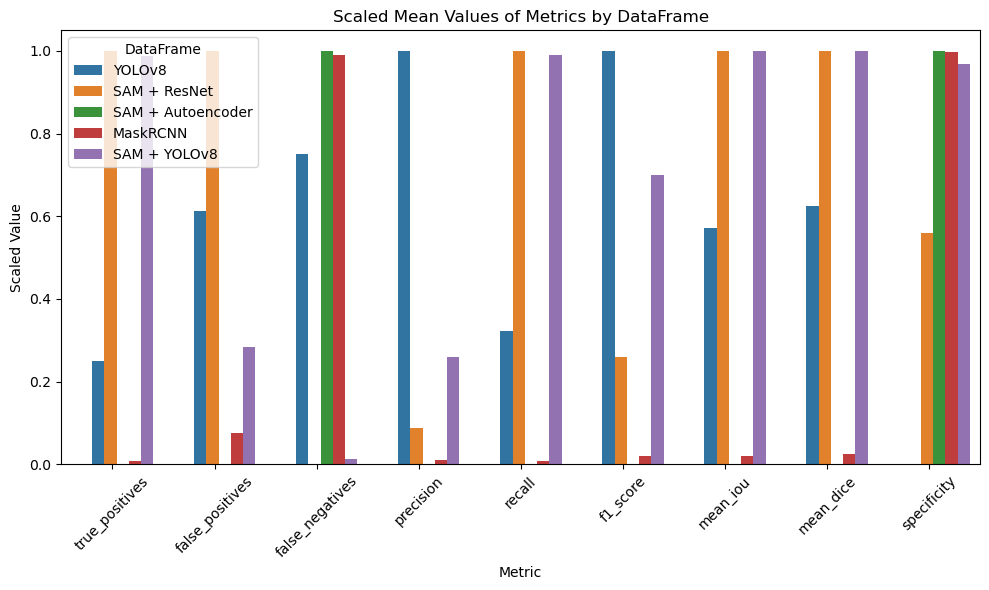

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Scaled Value', hue='DataFrame', data=scaled_df_melted, dodge=True, width=0.6)

# Adjust the spacing between bar groups
ax = plt.gca()
for patch in ax.patches:
    patch.set_x(patch.get_x() + 0.1)  # Increase this value to add more space between groups

plt.title('Scaled Mean Values of Metrics by DataFrame')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Classification evaluation (PyTorch only)

In [1]:
import os
import torch
import random
import numpy as np
import torch.nn as nn
from tqdm import tqdm
from PIL import Image, ImageDraw
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torchvision.datasets import CocoDetection

from ultralytics import YOLO
import torchvision.transforms.v2 as transforms

In [6]:
# Check if GPU is available
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [17]:
OUT_DIR = "out/evaluation"
os.makedirs(OUT_DIR, exist_ok=True)

In [2]:
class BinaryResnetClassifier(nn.Module):
    def __init__(self, num_classes=1):
        super(BinaryResnetClassifier, self).__init__()
        # Load a pre-trained ResNet model
        self.resnet = resnet50(ResNet50_Weights.IMAGENET1K_V1)  # You can choose any ResNet variant
        # Modify the last fully connected layer
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
        nn.init.xavier_normal_(self.resnet.fc.weight)
        
    def forward(self, x):
        # Pass the input through the ResNet
        x = self.resnet(x)
        # Apply the sigmoid activation function
#        x = torch.sigmoid(x)  # Output will be between 0 and 1
        return x

In [3]:
class Encoder(nn.Module):
    def __init__(self, in_channels=3, out_channels=16, latent_dim=200, act_fn=nn.ReLU()):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, stride=2),  # 112x112
            act_fn,
            nn.Conv2d(out_channels, 2*out_channels, 3, padding=1, stride=2),  # 56x56
            act_fn,
            nn.Conv2d(2*out_channels, 4*out_channels, 3, padding=1, stride=2),  # 28x28
            act_fn,
            nn.Conv2d(4*out_channels, 8*out_channels, 3, padding=1, stride=2),  # 14x14
            act_fn,
            nn.Conv2d(8*out_channels, 16*out_channels, 3, padding=1, stride=2),  # 7x7
            act_fn,
            nn.Flatten(),
            nn.Linear(16*out_channels*7*7, latent_dim),
            act_fn
        )

    def forward(self, x):
        return self.net(x)

class Decoder(nn.Module):
    def __init__(self, in_channels=3, out_channels=16, latent_dim=200, act_fn=nn.ReLU()):
        super().__init__()
        self.out_channels = out_channels
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 16*out_channels*7*7),
            act_fn
        )
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(16*out_channels, 8*out_channels, 3, stride=2, padding=1, output_padding=1),  # 14x14
            act_fn,
            nn.ConvTranspose2d(8*out_channels, 4*out_channels, 3, stride=2, padding=1, output_padding=1),  # 28x28
            act_fn,
            nn.ConvTranspose2d(4*out_channels, 2*out_channels, 3, stride=2, padding=1, output_padding=1),  # 56x56
            act_fn,
            nn.ConvTranspose2d(2*out_channels, out_channels, 3, stride=2, padding=1, output_padding=1),  # 112x112
            act_fn,
            nn.ConvTranspose2d(out_channels, in_channels, 3, stride=2, padding=1, output_padding=1),  # 224x224
        )

    def forward(self, x):
        output = self.linear(x)
        output = output.view(-1, 16*self.out_channels, 7, 7)
        output = self.conv(output)
        return output

#  defining autoencoder
class BigAutoencoder(nn.Module):
    def __init__(self, encoder=Encoder(), decoder=Decoder()):
        super().__init__()
        self.encoder = encoder
#        self.encoder.to(device)

        self.decoder = decoder
#        self.decoder.to(device)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [7]:
yolo = YOLO("out/yolo_urban_street/train/weights/best.pt")

resnet = torch.load("out/leaf_classifier/resnet/resnet_latest.pth")
resnet = resnet.to(device)
resnet.eval()

resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.RandomAffine(180, shear=45),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
])


autoencoder = torch.load("out/leaf_classifier/autoencoder/autoencoder_latest.pth")
autoencoder.eval()

autoencoder_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
])

In [8]:
def prep_img(img):
    return torch.Tensor(img).to(device).unsqueeze(0)

def predict_autoencoder(img):
    def pred(x):
        x = autoencoder_transform(prep_img(x))
        gt = autoencoder_transform(prep_img(img))
        with torch.no_grad():
            val = torch.sigmoid(nn.MSELoss()(autoencoder(x), gt)).item()
            return val < .75
    return pred(img)
    
def predict_resnet(img):
    def pred(x):
        x = resnet_transform(prep_img(x))
        with torch.no_grad():
            return resnet(x).item() > .5
    return pred(img)
    
def predict_yolo(img):
    return yolo.predict(img.unsqueeze(0))[0].masks is not None

In [9]:
classification_dict = {
    "ResNet": predict_resnet,
    "Autoencoder": predict_autoencoder,
    "YOLOv8": predict_yolo,
}

In [ ]:
import os
import json
from pycocotools.coco import COCO

def combine_coco_datasets(coco_files, output_file):
    combined_data = {
        'images': [],
        'annotations': [],
        'categories': []
    }

    category_mapping = {}
    current_image_id = 1  # Start from 1 for unique image IDs

    # Get the output directory from the output file path
    output_dir = os.path.dirname(output_file)

    for coco_file in coco_files:
        # Load COCO dataset
        coco = COCO(coco_file)

        # Extract the base directory from the COCO file path
        base_dir = os.path.dirname(coco_file)

        # Load categories and update the mapping
        categories = coco.loadCats(coco.getCatIds())
        for category in categories:
            if category['id'] not in category_mapping:
                category_mapping[category['id']] = {
                    'id': category['id'],
                    'name': category['name'],
                    'supercategory': category['supercategory']
                }

        # Update combined categories
        combined_data['categories'] = list(category_mapping.values())

        # Load images and annotations
        for img_id in coco.imgs.keys():
            img_info = coco.imgs[img_id]
            # Update image IDs to avoid duplication
            img_info['id'] = current_image_id

            # Convert the image file name to an absolute path
            img_info['file_name'] = os.path.abspath(os.path.join(base_dir, img_info['file_name']))
            combined_data['images'].append(img_info)
            current_image_id += 1

            # Load and update annotations
            annotation_ids = coco.getAnnIds(imgIds=img_id)
            for ann_id in annotation_ids:
                annotation = coco.anns[ann_id]
                annotation['image_id'] = img_info['id']  # Set the new image ID
                combined_data['annotations'].append(annotation)

    # Convert absolute paths back to relative paths based on the output directory
    #for img in combined_data['images']:
    #    img['file_name'] = os.path.relpath(img['file_name'], output_dir)

    # Save the combined dataset to a new JSON file
    with open(output_file, 'w') as f:
        json.dump(combined_data, f, indent=4)

In [5]:
COMBINE = False

coco_datasets = [
    "_data/validation/train/_annotations.coco.json",
    "_data/validation/test/_annotations.coco.json",
    "_data/validation/valid/_annotations.coco.json"
]

coco_output_file = "_data/validation_total.coco.json"

if COMBINE:
    combine_coco_datasets(coco_datasets, coco_output_file)

NameError: name 'combine_coco_datasets' is not defined

In [12]:
from pycocotools import mask as maskUtils
from pycocotools.coco import COCO

class CombinedDataset(Dataset):
    def __init__(self, coco_json_path, png_dir, coco_class_id, transform=None, max_png_files=None):
        """
        Args:
            coco_json_path (str): Path to COCO annotations JSON file.
            coco_images_dir (str): Directory containing COCO images.
            png_dir (str): Directory containing PNG files.
            coco_class_id (int): The COCO class ID to filter.
            transform (callable, optional): Optional transform to be applied on a sample.
            max_png_files (int, optional): Maximum number of PNG files to read.
        """
        self.coco = COCO(coco_json_path)
        self.png_files = [f for f in os.listdir(png_dir) if f.endswith('.png')]
        self.png_dir = png_dir
        self.coco_class_id = coco_class_id
        self.transform = transform
        self.max_png_files = max_png_files if max_png_files is not None else len(self.png_files)
        self.png_index = 0  # To track the current PNG file index
        self.image_ids = self.coco.getImgIds(catIds=[self.coco_class_id])
        self.total_coco_images = len(self.image_ids)

    def __len__(self):
        return self.total_coco_images + self.max_png_files

    def __getitem__(self, idx):
        if idx < self.total_coco_images:
            # Get COCO image ID
            img_id = self.image_ids[idx]
            img_info = self.coco.imgs[img_id]
            img_path = img_info['file_name']
            img = Image.open(img_path).convert('RGB')
            
            # Get segmentation masks
            ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=[self.coco_class_id])
            anns = self.coco.loadAnns(ann_ids)
            
            # Initialize a mask for the image
            mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)

            # Generate masks for each annotation and combine them
            for ann in anns:
                rle = maskUtils.frPyObjects(ann['segmentation'], img_info['height'], img_info['width'])
                mask += maskUtils.decode(rle).squeeze()  # Combine the mask with the existing mask

            # Convert the mask to a PIL image
            mask = Image.fromarray(mask.astype(np.uint8) * 255)  # Convert to 0-255 range

            # Apply the mask to the image
            img_with_mask = Image.new('RGB', img.size)
            img_with_mask.paste(img, (0, 0), mask)

            if self.transform:
                img_with_mask = self.transform(img_with_mask)

            return img_with_mask, 1

        else:
            # Load PNG files when COCO dataset is exhausted
            png_file = self.png_files[self.png_index]
            png_image = Image.open(os.path.join(self.png_dir, png_file)).convert('RGBA')
            # Extract the alpha channel as the mask
            mask = png_image.split()[-1]  # Get the alpha channel
            
            # Create an image with the alpha mask applied
            img_with_mask = Image.new('RGB', png_image.size)
            img_with_mask.paste(png_image, (0, 0), mask)

            self.png_index += 1
            if self.png_index >= self.max_png_files:
                self.png_index = 0  # Loop back to the start of PNG files

            if self.transform:
                img_with_mask = self.transform(img_with_mask)

            return img_with_mask, 0

In [13]:
# Define your transform
transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
])
subset_size = 1000
dataset = CombinedDataset(coco_output_file, 
                          png_dir="_data/synthetic-dataset-generation/data/distractors/openimage", 
                          coco_class_id=1,
                          transform=transform,
                          max_png_files=500)

# Create a DataLoader for the subset
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


torch.Size([3, 640, 640])


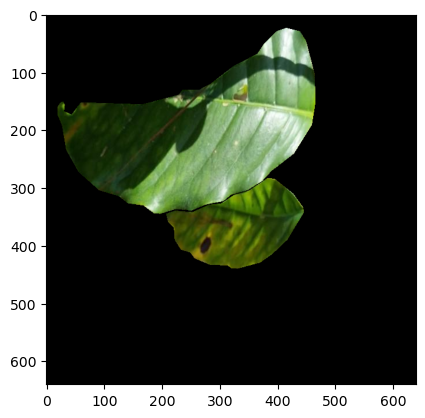

In [14]:
import matplotlib.pyplot as plt
img = next(iter(dataloader))[0][0]
print(img.shape)
plt.imshow(img.permute((1,2,0)))
plt.show()

In [15]:
def validate(model, dataloader, device):
    all_preds = []
    all_labels = []
    all_metrics = []  # List to store metrics for each batch
    
    with torch.no_grad():  # Disable gradient computation for validation
        for inputs, labels in tqdm(dataloader, total=len(dataloader)):
            inputs, labels = inputs.to(device), labels
            inputs = inputs.squeeze()
            
            # Forward pass
            outputs = model(inputs)
            preds = [int(outputs)]
            
            # Store predictions and true labels for metrics
            all_preds.extend(preds)
            all_labels.extend(labels)
            
            # Calculate metrics for the batch
            accuracy = accuracy_score(labels, preds)
            precision = precision_score(labels, preds, average='weighted', zero_division=0)
            recall = recall_score(labels, preds, average='weighted', zero_division=0)
            f1 = f1_score(labels, preds, average='weighted', zero_division=0)
            
            # Store metrics for this batch
            all_metrics.append({
                'batch_accuracy': accuracy,
                'batch_precision': precision,
                'batch_recall': recall,
                'batch_f1_score': f1
            })
    
    # Convert to DataFrame
    metrics_df = pd.DataFrame(all_metrics)
    
    # Compute overall metrics
    overall_accuracy = accuracy_score(all_labels, all_preds)
    overall_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    overall_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    overall_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    
    # Add overall metrics to the DataFrame
    overall_metrics = pd.DataFrame({
        'overall_accuracy': [overall_accuracy],
        'overall_precision': [overall_precision],
        'overall_recall': [overall_recall],
        'overall_f1_score': [overall_f1]
    })
    
    return metrics_df, overall_metrics, all_labels, all_preds

In [36]:
result_dfs = {}
overalls = {}
preds = {}
for name, func in classification_dict.items():
    print(f"Evaluating {name}")
    df, overall, y_true, y_pred = validate(func, dataloader, device)
    df.to_csv(f"out/evaluation/{name}_eval.csv")
    overall.to_csv(f"out/evaluation/{name}_overall.csv")
    result_dfs[name] = df
    overalls[name] = overall
    preds[name] = {
        'y_true': y_true,
        'y_pred': y_pred
    }
    print(overall)

Evaluating ResNet


100%|██████████| 851/851 [00:21<00:00, 39.75it/s]


   overall_accuracy  overall_precision  overall_recall  overall_f1_score
0          0.349001           0.316354        0.349001          0.267672
Evaluating Autoencoder


100%|██████████| 851/851 [00:16<00:00, 51.22it/s]


   overall_accuracy  overall_precision  overall_recall  overall_f1_score
0          0.414806           0.758065        0.414806          0.245968
Evaluating YOLOv8


  0%|          | 0/851 [00:00<?, ?it/s]


0: 640x640 1 leaf, 12.4ms
Speed: 0.0ms preprocess, 12.4ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 11.5ms
Speed: 0.0ms preprocess, 11.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 24.0ms
Speed: 0.0ms preprocess, 24.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 3/851 [00:00<00:33, 25.01it/s]


0: 640x640 (no detections), 14.9ms
Speed: 0.0ms preprocess, 14.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.2ms
Speed: 0.0ms preprocess, 10.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 6/851 [00:00<00:32, 26.15it/s]


0: 640x640 (no detections), 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 10/851 [00:00<00:27, 31.04it/s]


0: 640x640 (no detections), 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 14/851 [00:00<00:24, 33.53it/s]


0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 18/851 [00:00<00:24, 34.19it/s]


0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 22/851 [00:00<00:23, 34.97it/s]


0: 640x640 (no detections), 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 26/851 [00:00<00:24, 34.32it/s]


0: 640x640 2 leafs, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


  4%|▎         | 30/851 [00:00<00:23, 34.46it/s]


0: 640x640 1 leaf, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 11.3ms
Speed: 0.0ms preprocess, 11.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


  4%|▍         | 34/851 [00:01<00:24, 33.36it/s]


0: 640x640 1 leaf, 10.8ms
Speed: 0.0ms preprocess, 10.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 10.0ms
Speed: 0.0ms preprocess, 10.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 10.7ms
Speed: 0.0ms preprocess, 10.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 13.7ms
Speed: 0.0ms preprocess, 13.7ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)


  4%|▍         | 38/851 [00:01<00:25, 31.33it/s]


0: 640x640 (no detections), 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  5%|▍         | 42/851 [00:01<00:25, 31.71it/s]


0: 640x640 1 leaf, 10.3ms
Speed: 0.0ms preprocess, 10.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


  5%|▌         | 46/851 [00:01<00:25, 31.37it/s]


0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.8ms
Speed: 0.0ms preprocess, 9.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.0ms
Speed: 0.0ms preprocess, 10.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


  6%|▌         | 50/851 [00:01<00:26, 30.25it/s]


0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


  6%|▋         | 54/851 [00:01<00:25, 31.12it/s]


0: 640x640 1 leaf, 10.9ms
Speed: 0.0ms preprocess, 10.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 58/851 [00:01<00:25, 31.24it/s]


0: 640x640 2 leafs, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 11.0ms
Speed: 0.0ms preprocess, 11.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 62/851 [00:01<00:25, 30.47it/s]


0: 640x640 (no detections), 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 18.5ms
Speed: 0.0ms preprocess, 18.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 66/851 [00:02<00:28, 27.66it/s]


0: 640x640 (no detections), 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 70/851 [00:02<00:27, 28.48it/s]


0: 640x640 3 leafs, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 10.8ms
Speed: 0.0ms preprocess, 10.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.8ms
Speed: 0.0ms preprocess, 9.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


  9%|▊         | 74/851 [00:02<00:26, 29.43it/s]


0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


  9%|▉         | 77/851 [00:02<00:26, 29.17it/s]


0: 640x640 1 leaf, 11.0ms
Speed: 0.0ms preprocess, 11.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 10%|▉         | 81/851 [00:02<00:26, 28.81it/s]


0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.1ms
Speed: 0.0ms preprocess, 10.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 10%|▉         | 84/851 [00:02<00:26, 28.90it/s]


0: 640x640 (no detections), 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 10%|█         | 87/851 [00:02<00:26, 28.84it/s]


0: 640x640 (no detections), 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.9ms
Speed: 0.0ms preprocess, 9.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 91/851 [00:02<00:25, 30.04it/s]


0: 640x640 1 leaf, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 28.3ms
Speed: 0.0ms preprocess, 28.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 0.0ms preprocess, 12.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 10.6ms
Speed: 0.0ms preprocess, 10.6ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 95/851 [00:03<00:26, 28.45it/s]


0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 98/851 [00:03<00:26, 28.41it/s]


0: 640x640 1 leaf, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.0ms
Speed: 0.0ms preprocess, 11.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 101/851 [00:03<00:26, 28.67it/s]


0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 105/851 [00:03<00:26, 28.54it/s]


0: 640x640 (no detections), 10.1ms
Speed: 0.0ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 109/851 [00:03<00:25, 29.03it/s]


0: 640x640 2 leafs, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 12.8ms
Speed: 0.0ms preprocess, 12.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 113/851 [00:03<00:24, 29.64it/s]


0: 640x640 (no detections), 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▎        | 117/851 [00:03<00:23, 31.07it/s]


0: 640x640 1 leaf, 10.2ms
Speed: 0.0ms preprocess, 10.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.9ms
Speed: 0.0ms preprocess, 10.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▍        | 121/851 [00:03<00:23, 30.51it/s]


0: 640x640 2 leafs, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 16.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 21.2ms
Speed: 0.0ms preprocess, 21.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 10.8ms
Speed: 0.0ms preprocess, 10.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 10.7ms
Speed: 0.0ms preprocess, 10.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▍        | 125/851 [00:04<00:25, 28.49it/s]


0: 640x640 1 leaf, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▌        | 129/851 [00:04<00:23, 30.24it/s]


0: 640x640 1 leaf, 9.9ms
Speed: 0.0ms preprocess, 9.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 133/851 [00:04<00:22, 31.45it/s]


0: 640x640 (no detections), 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 10.0ms
Speed: 0.0ms preprocess, 10.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 137/851 [00:04<00:22, 32.24it/s]


0: 640x640 2 leafs, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 141/851 [00:04<00:21, 33.18it/s]


0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 10.0ms
Speed: 0.0ms preprocess, 10.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 10.2ms
Speed: 0.0ms preprocess, 10.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 145/851 [00:04<00:20, 34.17it/s]


0: 640x640 1 leaf, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 149/851 [00:04<00:20, 33.91it/s]


0: 640x640 (no detections), 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 10.1ms
Speed: 0.0ms preprocess, 10.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.9ms
Speed: 0.0ms preprocess, 10.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 153/851 [00:04<00:20, 33.41it/s]


0: 640x640 (no detections), 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 10.5ms
Speed: 0.0ms preprocess, 10.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 10.9ms
Speed: 0.0ms preprocess, 10.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 157/851 [00:05<00:21, 32.88it/s]


0: 640x640 (no detections), 11.1ms
Speed: 0.0ms preprocess, 11.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 15.7ms
Speed: 0.0ms preprocess, 15.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 161/851 [00:05<00:20, 32.93it/s]


0: 640x640 (no detections), 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 165/851 [00:05<00:22, 30.82it/s]


0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 20%|█▉        | 169/851 [00:05<00:21, 31.87it/s]


0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 11.1ms
Speed: 0.0ms preprocess, 11.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 20%|██        | 173/851 [00:05<00:21, 32.11it/s]


0: 640x640 (no detections), 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.8ms
Speed: 0.0ms preprocess, 9.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 21%|██        | 177/851 [00:05<00:21, 31.10it/s]


0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 21%|██▏       | 181/851 [00:05<00:21, 31.85it/s]


0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 11.3ms
Speed: 0.0ms preprocess, 11.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 185/851 [00:05<00:20, 33.06it/s]


0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 19.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 11.2ms
Speed: 0.0ms preprocess, 11.2ms inference, 9.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 10.4ms
Speed: 0.0ms preprocess, 10.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 189/851 [00:06<00:22, 29.88it/s]


0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 193/851 [00:06<00:25, 26.27it/s]


0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 196/851 [00:06<00:24, 26.49it/s]


0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▎       | 200/851 [00:06<00:22, 28.46it/s]


0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 204/851 [00:06<00:21, 30.10it/s]


0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 208/851 [00:06<00:20, 31.02it/s]


0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▍       | 212/851 [00:06<00:20, 31.79it/s]


0: 640x640 (no detections), 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.9ms
Speed: 0.0ms preprocess, 10.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 13.2ms
Speed: 0.0ms preprocess, 13.2ms inference, 8.3ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▌       | 216/851 [00:07<00:22, 28.66it/s]


0: 640x640 1 leaf, 20.7ms
Speed: 0.0ms preprocess, 20.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▌       | 219/851 [00:07<00:22, 27.97it/s]


0: 640x640 (no detections), 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▌       | 222/851 [00:07<00:22, 28.27it/s]


0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.8ms
Speed: 0.0ms preprocess, 9.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 226/851 [00:07<00:21, 29.41it/s]


0: 640x640 3 leafs, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.9ms
Speed: 0.0ms preprocess, 9.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 230/851 [00:07<00:20, 30.62it/s]


0: 640x640 2 leafs, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 234/851 [00:07<00:19, 30.97it/s]


0: 640x640 (no detections), 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 10.1ms
Speed: 0.0ms preprocess, 10.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 238/851 [00:07<00:21, 28.90it/s]


0: 640x640 1 leaf, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 242/851 [00:07<00:20, 29.60it/s]


0: 640x640 1 leaf, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 16.5ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 245/851 [00:08<00:21, 28.59it/s]


0: 640x640 (no detections), 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 10.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.7ms
Speed: 0.0ms preprocess, 10.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.9ms
Speed: 0.0ms preprocess, 9.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 248/851 [00:08<00:21, 28.63it/s]


0: 640x640 (no detections), 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 30%|██▉       | 252/851 [00:08<00:19, 31.06it/s]


0: 640x640 1 leaf, 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 30%|███       | 256/851 [00:08<00:18, 31.72it/s]


0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 260/851 [00:08<00:18, 32.22it/s]


0: 640x640 1 leaf, 11.0ms
Speed: 0.0ms preprocess, 11.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 264/851 [00:08<00:18, 32.47it/s]


0: 640x640 (no detections), 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.7ms
Speed: 0.0ms preprocess, 10.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 31%|███▏      | 268/851 [00:08<00:18, 30.99it/s]


0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 12.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 10.9ms
Speed: 0.0ms preprocess, 10.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 10.5ms
Speed: 0.0ms preprocess, 10.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 272/851 [00:08<00:20, 27.84it/s]


0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 276/851 [00:09<00:19, 28.80it/s]


0: 640x640 (no detections), 22.1ms
Speed: 0.0ms preprocess, 22.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 11.2ms
Speed: 0.0ms preprocess, 11.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.0ms
Speed: 0.0ms preprocess, 11.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 279/851 [00:09<00:19, 28.99it/s]


0: 640x640 1 leaf, 10.3ms
Speed: 0.0ms preprocess, 10.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 18.4ms
Speed: 0.0ms preprocess, 18.4ms inference, 10.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 13.1ms
Speed: 0.0ms preprocess, 13.1ms inference, 11.0ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 282/851 [00:09<00:21, 26.40it/s]


0: 640x640 1 leaf, 13.2ms
Speed: 0.0ms preprocess, 13.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.0ms
Speed: 0.0ms preprocess, 12.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 13.8ms
Speed: 0.0ms preprocess, 13.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 285/851 [00:09<00:21, 26.34it/s]


0: 640x640 (no detections), 14.2ms
Speed: 0.0ms preprocess, 14.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 289/851 [00:09<00:19, 28.21it/s]


0: 640x640 1 leaf, 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 292/851 [00:09<00:19, 28.45it/s]


0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▍      | 295/851 [00:09<00:19, 28.23it/s]


0: 640x640 (no detections), 10.2ms
Speed: 0.0ms preprocess, 10.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▌      | 299/851 [00:09<00:19, 28.87it/s]


0: 640x640 (no detections), 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 0.0ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▌      | 303/851 [00:10<00:17, 30.52it/s]


0: 640x640 1 leaf, 10.1ms
Speed: 0.0ms preprocess, 10.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 10.5ms
Speed: 0.0ms preprocess, 10.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 14.2ms
Speed: 0.0ms preprocess, 14.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▌      | 307/851 [00:10<00:18, 29.41it/s]


0: 640x640 (no detections), 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 311/851 [00:10<00:17, 31.27it/s]


0: 640x640 (no detections), 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 315/851 [00:10<00:16, 33.26it/s]


0: 640x640 1 leaf, 10.2ms
Speed: 0.0ms preprocess, 10.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 319/851 [00:10<00:15, 34.15it/s]


0: 640x640 1 leaf, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 323/851 [00:10<00:15, 34.82it/s]


0: 640x640 (no detections), 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 327/851 [00:10<00:15, 34.21it/s]


0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▉      | 331/851 [00:10<00:14, 34.86it/s]


0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 leafs, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▉      | 335/851 [00:10<00:14, 35.16it/s]


0: 640x640 (no detections), 10.0ms
Speed: 0.0ms preprocess, 10.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.6ms
Speed: 0.0ms preprocess, 10.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.9ms
Speed: 0.0ms preprocess, 9.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 40%|███▉      | 339/851 [00:11<00:15, 33.59it/s]


0: 640x640 1 leaf, 10.8ms
Speed: 0.0ms preprocess, 10.8ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 40%|████      | 343/851 [00:11<00:16, 31.52it/s]


0: 640x640 1 leaf, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 41%|████      | 347/851 [00:11<00:15, 32.96it/s]


0: 640x640 1 leaf, 9.8ms
Speed: 0.0ms preprocess, 9.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 41%|████      | 351/851 [00:11<00:14, 33.51it/s]


0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 355/851 [00:11<00:14, 33.66it/s]


0: 640x640 (no detections), 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 359/851 [00:11<00:14, 33.08it/s]


0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 363/851 [00:11<00:17, 27.84it/s]


0: 640x640 2 leafs, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 366/851 [00:11<00:17, 28.18it/s]


0: 640x640 (no detections), 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 16.8ms
Speed: 0.0ms preprocess, 16.8ms inference, 10.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 11.0ms
Speed: 0.0ms preprocess, 11.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 369/851 [00:12<00:18, 25.69it/s]


0: 640x640 1 leaf, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▎     | 372/851 [00:12<00:18, 25.40it/s]


0: 640x640 1 leaf, 11.5ms
Speed: 0.0ms preprocess, 11.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.8ms
Speed: 0.0ms preprocess, 9.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 375/851 [00:12<00:21, 22.44it/s]


0: 640x640 (no detections), 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 378/851 [00:12<00:19, 23.76it/s]


0: 640x640 (no detections), 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.8ms
Speed: 0.0ms preprocess, 9.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▍     | 382/851 [00:12<00:18, 25.79it/s]


0: 640x640 2 leafs, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.0ms
Speed: 0.0ms preprocess, 10.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▌     | 386/851 [00:12<00:16, 27.42it/s]


0: 640x640 (no detections), 10.0ms
Speed: 0.0ms preprocess, 10.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 390/851 [00:12<00:15, 28.96it/s]


0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 10.2ms
Speed: 0.0ms preprocess, 10.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 393/851 [00:13<00:15, 28.67it/s]


0: 640x640 (no detections), 13.3ms
Speed: 0.0ms preprocess, 13.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.1ms
Speed: 0.0ms preprocess, 10.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 14.0ms
Speed: 0.0ms preprocess, 14.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 396/851 [00:13<00:17, 25.92it/s]


0: 640x640 2 leafs, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 10.3ms
Speed: 0.0ms preprocess, 10.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 400/851 [00:13<00:15, 28.61it/s]


0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.8ms
Speed: 0.0ms preprocess, 9.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 10.1ms
Speed: 0.0ms preprocess, 10.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 403/851 [00:13<00:15, 28.97it/s]


0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 407/851 [00:13<00:14, 29.93it/s]


0: 640x640 2 leafs, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 411/851 [00:13<00:14, 30.60it/s]


0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.8ms
Speed: 0.0ms preprocess, 9.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 415/851 [00:13<00:13, 31.95it/s]


0: 640x640 (no detections), 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 419/851 [00:13<00:12, 33.31it/s]


0: 640x640 1 leaf, 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 50%|████▉     | 423/851 [00:13<00:12, 33.83it/s]


0: 640x640 1 leaf, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.9ms
Speed: 0.0ms preprocess, 10.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 10.0ms
Speed: 0.0ms preprocess, 10.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.8ms
Speed: 0.0ms preprocess, 10.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 50%|█████     | 427/851 [00:14<00:13, 31.40it/s]


0: 640x640 (no detections), 16.4ms
Speed: 0.0ms preprocess, 16.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 12.2ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████     | 431/851 [00:14<00:15, 27.99it/s]


0: 640x640 (no detections), 14.2ms
Speed: 0.0ms preprocess, 14.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 18.6ms
Speed: 0.0ms preprocess, 18.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 21.9ms
Speed: 0.0ms preprocess, 21.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████     | 434/851 [00:14<00:16, 25.32it/s]


0: 640x640 1 leaf, 21.9ms
Speed: 0.0ms preprocess, 21.9ms inference, 14.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████▏    | 437/851 [00:14<00:18, 22.90it/s]


0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 11.2ms
Speed: 0.0ms preprocess, 11.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 440/851 [00:14<00:17, 23.89it/s]


0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 444/851 [00:14<00:15, 26.39it/s]


0: 640x640 1 leaf, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 448/851 [00:14<00:14, 27.93it/s]


0: 640x640 1 leaf, 10.2ms
Speed: 0.0ms preprocess, 10.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 7.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 451/851 [00:15<00:15, 25.62it/s]


0: 640x640 (no detections), 9.9ms
Speed: 0.0ms preprocess, 9.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 455/851 [00:15<00:14, 28.14it/s]


0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▍    | 459/851 [00:15<00:13, 29.51it/s]


0: 640x640 1 leaf, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▍    | 463/851 [00:15<00:13, 29.06it/s]


0: 640x640 (no detections), 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▍    | 467/851 [00:15<00:12, 30.16it/s]


0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▌    | 471/851 [00:15<00:12, 30.90it/s]


0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▌    | 475/851 [00:15<00:12, 30.97it/s]


0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▋    | 479/851 [00:15<00:11, 31.77it/s]


0: 640x640 (no detections), 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 10.7ms
Speed: 0.0ms preprocess, 10.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 11.1ms
Speed: 0.0ms preprocess, 11.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 10.6ms
Speed: 0.0ms preprocess, 10.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 483/851 [00:16<00:12, 29.64it/s]


0: 640x640 1 leaf, 11.3ms
Speed: 0.0ms preprocess, 11.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 487/851 [00:16<00:11, 30.87it/s]


0: 640x640 1 leaf, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 0.0ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 491/851 [00:16<00:11, 31.83it/s]


0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 495/851 [00:16<00:12, 28.44it/s]


0: 640x640 (no detections), 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▊    | 499/851 [00:16<00:11, 30.38it/s]


0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 503/851 [00:16<00:11, 30.03it/s]


0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 60%|█████▉    | 507/851 [00:16<00:11, 30.97it/s]


0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 8.5ms postprocess per image at shape (1, 3, 640, 640)


 60%|██████    | 511/851 [00:17<00:11, 28.52it/s]


0: 640x640 (no detections), 10.1ms
Speed: 0.0ms preprocess, 10.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.9ms
Speed: 0.0ms preprocess, 9.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 0.0ms preprocess, 9.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 60%|██████    | 514/851 [00:17<00:11, 28.58it/s]


0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 518/851 [00:17<00:10, 30.58it/s]


0: 640x640 (no detections), 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████▏   | 522/851 [00:17<00:10, 32.07it/s]


0: 640x640 1 leaf, 10.4ms
Speed: 0.0ms preprocess, 10.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 526/851 [00:17<00:11, 29.08it/s]


0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 530/851 [00:17<00:10, 30.94it/s]


0: 640x640 1 leaf, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 534/851 [00:17<00:09, 31.87it/s]


0: 640x640 (no detections), 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 538/851 [00:17<00:10, 30.91it/s]


0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 10.3ms
Speed: 0.0ms preprocess, 10.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 11.3ms
Speed: 0.0ms preprocess, 11.3ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▎   | 542/851 [00:18<00:11, 27.58it/s]


0: 640x640 (no detections), 9.9ms
Speed: 0.0ms preprocess, 9.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.4ms
Speed: 0.0ms preprocess, 10.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 546/851 [00:18<00:10, 28.96it/s]


0: 640x640 1 leaf, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 leafs, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▍   | 550/851 [00:18<00:10, 29.88it/s]


0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▌   | 554/851 [00:18<00:09, 30.42it/s]


0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 558/851 [00:18<00:09, 29.66it/s]


0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 562/851 [00:18<00:09, 29.38it/s]


0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 566/851 [00:18<00:09, 30.56it/s]


0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 31.7ms
Speed: 0.0ms preprocess, 31.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 570/851 [00:19<00:09, 29.43it/s]


0: 640x640 2 leafs, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 573/851 [00:19<00:10, 27.11it/s]


0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 577/851 [00:19<00:09, 28.73it/s]


0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 581/851 [00:19<00:09, 29.69it/s]


0: 640x640 1 leaf, 11.1ms
Speed: 0.0ms preprocess, 11.1ms inference, 16.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 10.4ms
Speed: 0.0ms preprocess, 10.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▊   | 584/851 [00:19<00:09, 26.97it/s]


0: 640x640 (no detections), 10.8ms
Speed: 0.0ms preprocess, 10.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▉   | 587/851 [00:19<00:09, 27.53it/s]


0: 640x640 1 leaf, 11.4ms
Speed: 0.0ms preprocess, 11.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 11.2ms
Speed: 0.0ms preprocess, 11.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 10.2ms
Speed: 0.0ms preprocess, 10.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▉   | 590/851 [00:19<00:10, 25.00it/s]


0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 23.2ms
Speed: 0.0ms preprocess, 23.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 70%|██████▉   | 593/851 [00:19<00:10, 25.24it/s]


0: 640x640 (no detections), 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 70%|███████   | 596/851 [00:20<00:11, 22.98it/s]


0: 640x640 1 leaf, 10.0ms
Speed: 0.0ms preprocess, 10.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.1ms
Speed: 0.0ms preprocess, 10.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 12.2ms
Speed: 0.0ms preprocess, 12.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 70%|███████   | 599/851 [00:20<00:10, 24.27it/s]


0: 640x640 (no detections), 10.1ms
Speed: 0.0ms preprocess, 10.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 11.9ms
Speed: 0.0ms preprocess, 11.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████   | 603/851 [00:20<00:09, 26.72it/s]


0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████   | 606/851 [00:20<00:09, 27.12it/s]


0: 640x640 1 leaf, 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 610/851 [00:20<00:08, 29.42it/s]


0: 640x640 (no detections), 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 614/851 [00:20<00:07, 29.64it/s]


0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 618/851 [00:20<00:07, 30.99it/s]


0: 640x640 1 leaf, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 622/851 [00:20<00:07, 31.92it/s]


0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 10.9ms
Speed: 0.0ms preprocess, 10.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▎  | 626/851 [00:21<00:07, 30.18it/s]


0: 640x640 1 leaf, 10.1ms
Speed: 0.0ms preprocess, 10.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 10.7ms
Speed: 0.0ms preprocess, 10.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 11.5ms
Speed: 0.0ms preprocess, 11.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▍  | 630/851 [00:21<00:07, 29.42it/s]


0: 640x640 (no detections), 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▍  | 634/851 [00:21<00:06, 31.16it/s]


0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.8ms
Speed: 0.0ms preprocess, 9.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▍  | 638/851 [00:21<00:06, 31.42it/s]


0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▌  | 642/851 [00:21<00:06, 31.96it/s]


0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 10.5ms
Speed: 0.0ms preprocess, 10.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▌  | 646/851 [00:21<00:06, 31.59it/s]


0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 10.0ms
Speed: 0.0ms preprocess, 10.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▋  | 650/851 [00:21<00:06, 30.98it/s]


0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 654/851 [00:21<00:06, 31.81it/s]


0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.6ms
Speed: 0.0ms preprocess, 10.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 11.2ms
Speed: 0.0ms preprocess, 11.2ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 658/851 [00:22<00:06, 28.93it/s]


0: 640x640 (no detections), 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 10.8ms
Speed: 0.0ms preprocess, 10.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 662/851 [00:22<00:06, 29.58it/s]


0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 666/851 [00:22<00:06, 29.27it/s]


0: 640x640 1 leaf, 10.9ms
Speed: 0.0ms preprocess, 10.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 10.3ms
Speed: 0.0ms preprocess, 10.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▊  | 670/851 [00:22<00:06, 30.03it/s]


0: 640x640 1 leaf, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.3ms
Speed: 0.0ms preprocess, 10.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 674/851 [00:22<00:05, 30.42it/s]


0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 80%|███████▉  | 678/851 [00:22<00:05, 31.34it/s]


0: 640x640 (no detections), 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 10.8ms
Speed: 0.0ms preprocess, 10.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 10.6ms
Speed: 0.0ms preprocess, 10.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 80%|████████  | 682/851 [00:22<00:05, 31.82it/s]


0: 640x640 (no detections), 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████  | 686/851 [00:22<00:05, 32.20it/s]


0: 640x640 (no detections), 22.7ms
Speed: 0.0ms preprocess, 22.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 20.2ms
Speed: 0.0ms preprocess, 20.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 12.6ms
Speed: 0.0ms preprocess, 12.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████  | 690/851 [00:23<00:05, 28.55it/s]


0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 694/851 [00:23<00:05, 28.12it/s]


0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 9.8ms
Speed: 0.0ms preprocess, 9.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 698/851 [00:23<00:05, 29.29it/s]


0: 640x640 2 leafs, 10.0ms
Speed: 0.0ms preprocess, 10.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 701/851 [00:23<00:05, 27.79it/s]


0: 640x640 (no detections), 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.8ms
Speed: 0.0ms preprocess, 9.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 705/851 [00:23<00:04, 29.29it/s]


0: 640x640 (no detections), 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 709/851 [00:23<00:04, 30.24it/s]


0: 640x640 (no detections), 9.9ms
Speed: 0.0ms preprocess, 9.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 713/851 [00:23<00:04, 31.16it/s]


0: 640x640 (no detections), 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.7ms
Speed: 0.0ms preprocess, 10.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 10.4ms
Speed: 0.0ms preprocess, 10.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 717/851 [00:24<00:04, 31.28it/s]


0: 640x640 1 leaf, 10.2ms
Speed: 0.0ms preprocess, 10.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 14.8ms
Speed: 0.0ms preprocess, 14.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▍ | 721/851 [00:24<00:04, 30.94it/s]


0: 640x640 (no detections), 10.0ms
Speed: 0.0ms preprocess, 10.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▌ | 725/851 [00:24<00:03, 32.14it/s]


0: 640x640 (no detections), 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▌ | 729/851 [00:24<00:03, 31.25it/s]


0: 640x640 (no detections), 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▌ | 733/851 [00:24<00:03, 31.74it/s]


0: 640x640 (no detections), 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.0ms
Speed: 0.0ms preprocess, 10.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 737/851 [00:24<00:03, 32.64it/s]


0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 13.8ms
Speed: 0.0ms preprocess, 13.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 741/851 [00:24<00:04, 25.05it/s]


0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 19.3ms
Speed: 0.0ms preprocess, 19.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 745/851 [00:25<00:04, 25.16it/s]


0: 640x640 (no detections), 10.7ms
Speed: 0.0ms preprocess, 10.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 10.4ms
Speed: 0.0ms preprocess, 10.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 10.7ms
Speed: 0.0ms preprocess, 10.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 748/851 [00:25<00:04, 25.48it/s]


0: 640x640 (no detections), 10.6ms
Speed: 0.0ms preprocess, 10.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 20.7ms
Speed: 0.0ms preprocess, 20.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 18.5ms
Speed: 0.0ms preprocess, 18.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 751/851 [00:25<00:04, 24.38it/s]


0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▊ | 754/851 [00:25<00:03, 25.01it/s]


0: 640x640 1 leaf, 10.1ms
Speed: 0.0ms preprocess, 10.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▉ | 758/851 [00:25<00:03, 26.05it/s]


0: 640x640 1 leaf, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 10.0ms
Speed: 0.0ms preprocess, 10.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 90%|████████▉ | 762/851 [00:25<00:03, 27.89it/s]


0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 90%|████████▉ | 765/851 [00:25<00:03, 27.69it/s]


0: 640x640 1 leaf, 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 10.1ms
Speed: 0.0ms preprocess, 10.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 90%|█████████ | 769/851 [00:25<00:02, 28.94it/s]


0: 640x640 1 leaf, 23.1ms
Speed: 0.0ms preprocess, 23.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 22.0ms
Speed: 0.0ms preprocess, 22.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 11.5ms
Speed: 0.0ms preprocess, 11.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 772/851 [00:26<00:03, 20.18it/s]


0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 776/851 [00:26<00:03, 23.08it/s]


0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 780/851 [00:26<00:02, 25.50it/s]


0: 640x640 1 leaf, 9.8ms
Speed: 0.0ms preprocess, 9.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 784/851 [00:26<00:02, 27.94it/s]


0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 788/851 [00:26<00:02, 29.27it/s]


0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.8ms
Speed: 0.0ms preprocess, 12.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 0.0ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 792/851 [00:26<00:02, 28.78it/s]


0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▎| 796/851 [00:26<00:01, 30.96it/s]


0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.8ms
Speed: 0.0ms preprocess, 9.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 800/851 [00:27<00:01, 30.17it/s]


0: 640x640 1 leaf, 10.1ms
Speed: 0.0ms preprocess, 10.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.1ms
Speed: 0.0ms preprocess, 10.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 804/851 [00:27<00:01, 30.20it/s]


0: 640x640 (no detections), 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▍| 808/851 [00:27<00:01, 31.84it/s]


0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▌| 812/851 [00:27<00:01, 32.80it/s]


0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▌| 816/851 [00:27<00:01, 32.93it/s]


0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▋| 820/851 [00:27<00:00, 31.63it/s]


0: 640x640 1 leaf, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 824/851 [00:27<00:00, 32.02it/s]


0: 640x640 1 leaf, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 828/851 [00:27<00:00, 32.51it/s]


0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.0ms
Speed: 0.0ms preprocess, 11.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 10.1ms
Speed: 0.0ms preprocess, 10.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 832/851 [00:28<00:00, 31.68it/s]


0: 640x640 1 leaf, 10.3ms
Speed: 0.0ms preprocess, 10.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 17.3ms
Speed: 0.0ms preprocess, 17.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 836/851 [00:28<00:00, 30.71it/s]


0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▊| 840/851 [00:28<00:00, 31.01it/s]


0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 0.0ms preprocess, 9.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 844/851 [00:28<00:00, 31.49it/s]


0: 640x640 1 leaf, 11.4ms
Speed: 0.0ms preprocess, 11.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


100%|█████████▉| 848/851 [00:28<00:00, 31.54it/s]


0: 640x640 1 leaf, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


100%|██████████| 851/851 [00:28<00:00, 29.66it/s]


   overall_accuracy  overall_precision  overall_recall  overall_f1_score
0          0.670975           0.802232        0.670975          0.656197


In [37]:
models_metrics = dict()

for key, value in overalls.items():
    models_metrics[key] = dict()
    for subkey, subvalue in value.items():
        models_metrics[key][subkey] = float(subvalue.iloc[0])

df = pd.DataFrame.from_dict(models_metrics, orient='index')

# Reset index to turn the model names into a column
df.reset_index(inplace=True)

# Rename the index column to 'model'
df.rename(columns={'index': 'model'}, inplace=True)

# Convert DataFrame to long format
df_long = pd.melt(df, id_vars=['model'], var_name='metric', value_name='value')

In [38]:
rename_dict = {
    'overall_accuracy': 'Accuracy',
    'overall_precision': 'Precision',
    'overall_recall': 'Recall',
    'overall_f1_score': 'F1-Score'
}

df_long['metric'] = df_long['metric'].replace(rename_dict)

df_long

,model,metric,value
0,ResNet,Accuracy,0.349001
1,Autoencoder,Accuracy,0.414806
2,YOLOv8,Accuracy,0.670975
3,ResNet,Precision,0.316354
4,Autoencoder,Precision,0.758065
5,YOLOv8,Precision,0.802232
6,ResNet,Recall,0.349001
7,Autoencoder,Recall,0.414806
8,YOLOv8,Recall,0.670975
9,ResNet,F1-Score,0.267672


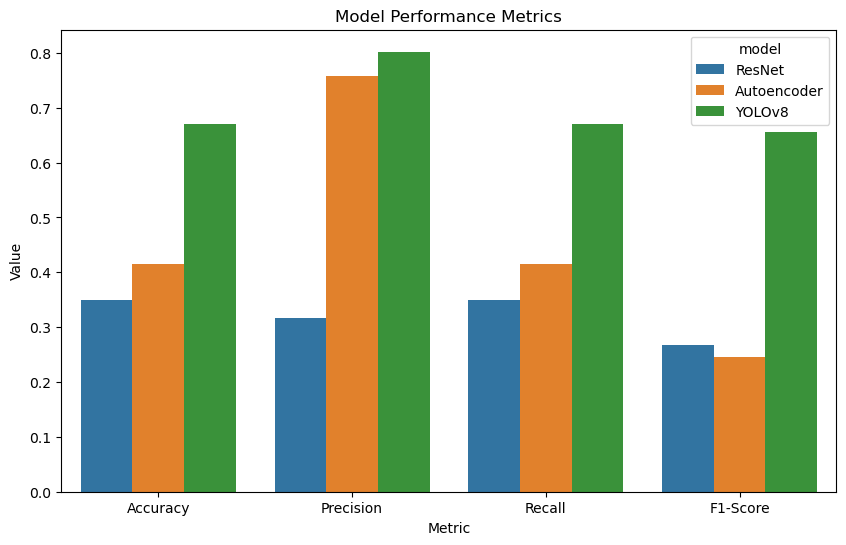

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a grouped bar plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='metric', y='value', hue='model', data=df_long)

# Add labels and title
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Model Performance Metrics')

# Show plot
plt.show()

In [40]:
import matplotlib.pyplot as plt

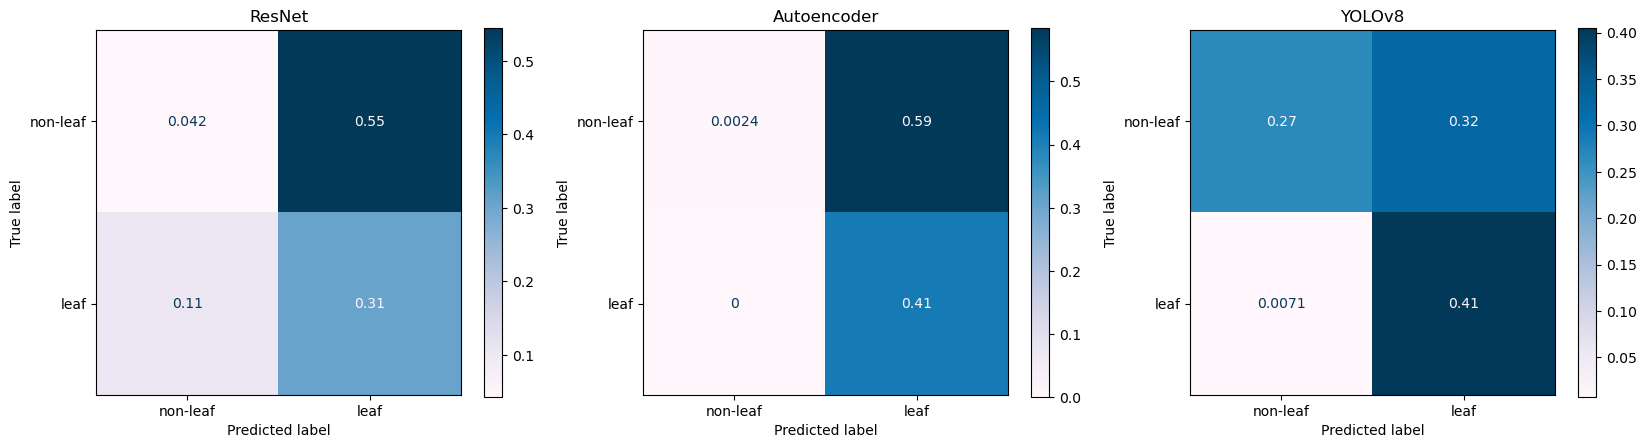

In [78]:
from sklearn.metrics import ConfusionMatrixDisplay
fig, axs = plt.subplots(1, 3)
fig.set_figwidth(20)
axs = axs.flatten()
for ax, (name, data) in zip(axs, preds.items()):
    data['y_true'] = [x.item() if type(x) is not int else x for x in data['y_true']]
    disp = ConfusionMatrixDisplay.from_predictions(
        data['y_true'],
        data['y_pred'],
        cmap=plt.cm.PuBu,
        normalize='all',
        display_labels=['non-leaf', 'leaf'],
        ax=ax
    )
    disp.ax_.set_title(name)
plt.show()

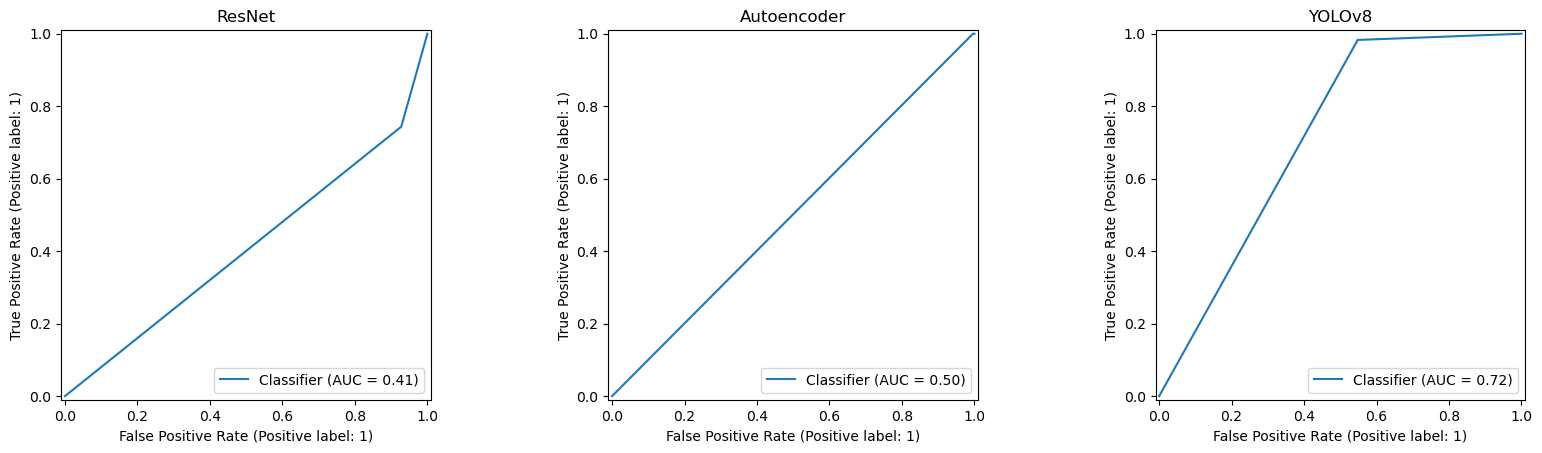

In [80]:
from sklearn.metrics import ConfusionMatrixDisplay
fig, axs = plt.subplots(1, 3)
fig.set_figwidth(20)
axs = axs.flatten()
for ax, (name, data) in zip(axs, preds.items()):
    data['y_true'] = [x.item() if type(x) is not int else x for x in data['y_true']]
    disp = RocCurveDisplay.from_predictions(
        data['y_true'],
        data['y_pred'],
        ax=ax
    )
    disp.ax_.set_title(name)
plt.show()

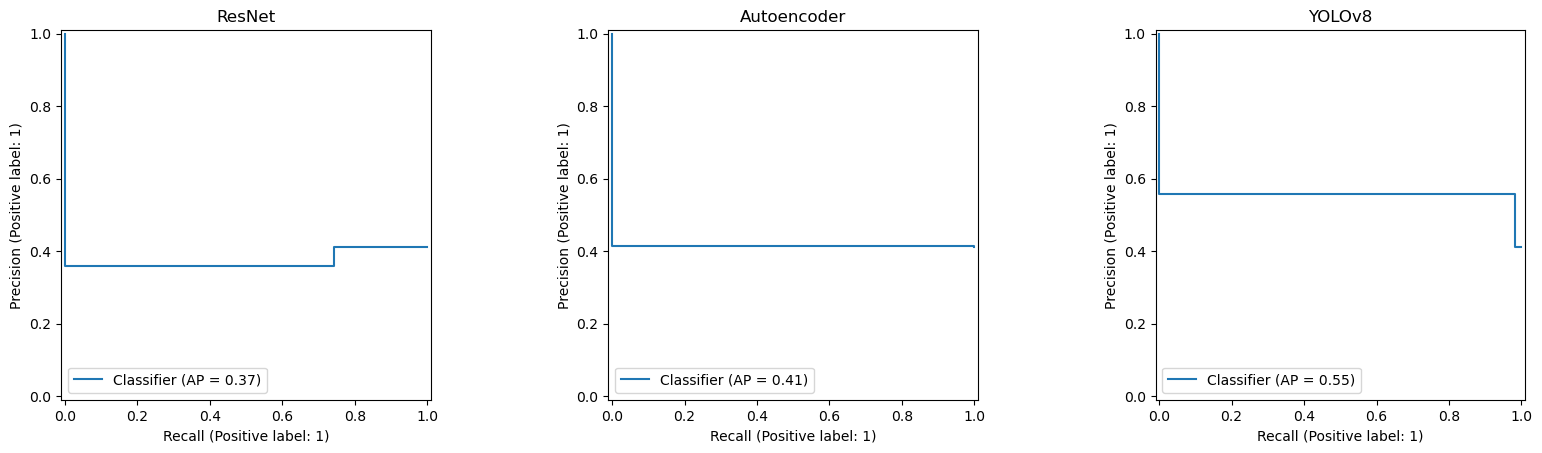

In [83]:
from sklearn.metrics import ConfusionMatrixDisplay
fig, axs = plt.subplots(1, 3)
fig.set_figwidth(20)
axs = axs.flatten()
for ax, (name, data) in zip(axs, preds.items()):
    data['y_true'] = [x.item() if type(x) is not int else x for x in data['y_true']]
    disp = PrecisionRecallDisplay.from_predictions(
        data['y_true'],
        data['y_pred'],
        ax=ax
    )
    disp.ax_.set_title(name)
plt.show()